## IBM QX 14-qubit device:
### Scalable characterization of all symmetrized Pauli error rates


There are three different two qubit configuration setups, rather than doing them sequentially the different sequences for the different setups were run in an interleaved manner (i.e. seq for run-type-1, seq for run-type-2, seq for run-type-3, seq for run type-1 ... etc). This was done in an attempt to 'average' out machine drift when comparing the runs.


<span style="color:blue">
The purpose of this notebook is to analyze data from the IBM 14-qubit quantum device (Melbourne) taken using the scalable noise reconstruction protocol for estimating averaged Pauli error rates. The full protocol for estimating all of the Pauli error rates requires the ability to generate a 14-qubit Clifford gate, and this is too ambitious for this device. Therefore, we focus on the simpler task of estimating the _symmetrized_ error rates, where we twirl with $n$ copies of the single-qubit Clifford group/twin-qubit Clifford group instead of the Pauli group. </span>

    
In this worksheet we will use bootstrapping to give error bars.


*There is an earlier workbook **SingleQubitGates14QCliffordsBootstrap** that contains runs with single Clifford gates.*

**Note:** 
  -   the bootstrapping cells are quite time-intenstive 30 mins ~ 1 hour, so they have been disabled and previously generated results are loaded in.
  -   graph saving commands have been commented out, so previously generated graphs are not over-written.
  -   even on a desktop the reading and processing of the bootstrapped files (for error bars) can take quite a few minutes each.
  
**Note:**  This workbook analyses runs where we had multiple two qubit twirls (6 of them) going on simultaneously). There is another workbook where we did many runs where there was only 1 two qubit twirl - again the results of that are interesting.

# Initial Data Load

In [1]:
using LsqFit
using PyPlot
# convenience (type /otimes<tab>)
⊗ = kron

kron (generic function with 39 methods)

In [2]:
using GZip

In [3]:
using Juqst

In [4]:
# The drawing code is kept seperate - some of it is quite particular to the IBM machines
include("marginalDrawing.jl")

covhinton

In [5]:
modelF(x, p) = p[1]*(p[2].^x)

modelF (generic function with 1 method)

## These runs include a '0' gate run ie. just potentially an X gate to make B=0.5



### So this is the original probability distribution. 

To bootstrap turn into a cumulative sum and then recreate by rolling dice.

In [6]:
function bootStrappedMatrices(size,shots,cumulativeMatrix)
    toRet = []
    for todo = 1:length(cumulativeMatrix)
        counted = zeros(size)
        rolls = rand(shots)
        for i in rolls
            #using the fact that the cululativeMatrix is (effectively) sorted.
            counted[searchsortedfirst(cumulativeMatrix[todo],i,)] +=1
        end
        push!(toRet,counted./shots)
    end
    return toRet
end

bootStrappedMatrices (generic function with 1 method)

In [7]:
# The re-run of single qubit had a longer tail. Vcat just to turn it into a vector.
twoQubitLengths=vcat([],0:10);

In [8]:
using ProgressMeter

In [9]:
### Because of the way it was saved we need to translate the 'thousandParam' style of things.
### Actually this is not used in this workbook, as the files were too long to put in the repo.
### And we don't need them for this workbook.

function translateThousandCSV(temp)
    # The param lists (why not tuples?) saved as e.g. "[0.859164"  " 0.993246]" , so just filter out non-number stuff and parse.
    return [[[
                parse(Float64,filter(x->isdigit(x) || x=='.',temp[ix,i])),
                parse(Float64,filter(x->isdigit(x) || x=='.',temp[ix,i+1]))] 
                        for i = 1:2:length(temp[ix,:])] 
                                                                for ix = 1:size(temp)[1]]
end


translateThousandCSV (generic function with 1 method)

## Some formulas allowing us to look at the spread of relative entropy between the bootstrapped matrices and the data matrix.


$D_{KL}(P||Q) = -\sum\limits_{x}P(x)\log\left(\frac{P(x)}{Q(x)}\right) = \sum\limits_{x}P(x)\log\left(\frac{Q(x)}{P(x)}\right)$



### We can look at the Relative Entropy between our $\tilde{\,p}_1$ and the reconstructed p

$D_{KL}(P||Q) = \sum\limits_{j}p_j\log\frac{p_j}{q_j}$

### Jensen Shannon divergence 

The problem with D is is that the gibbs field reconstruction is not necessarily going to be zero everywhere our 'observed' projected probability is zero.

Better in this case to use the Jensen-Shannon divergence

$\text{JSD}(P||Q) = \frac{1}{2}D(P||M) + \frac{1}{2}D(Q||M), M = \frac{1}{2}(P+Q)$


## And now to deal with the two qubit runs.

In [10]:
# Read in the raw results stored on a per sequence length
# Binary valued so first entry = 0000000000000000
# Then a 1 on qubit 0 is the second entry i.e. 0000000000000001
# all the way to a 1 on all qubits 111111111111111111111111


using DelimitedFiles
fullMatrix1 = readdlm("./data/results14InterleavedAC_0.csv",',',Int64);
fullMatrix2 = readdlm("./data/results14InterleavedAC_1.csv",',',Int64);
fullMatrix3 = readdlm("./data/results14InterleavedAC_2.csv",',',Int64);


In [11]:
fullMatrix1

11×16384 Matrix{Int64}:
 367287  17174  123893  5874  16758  …    0    0   0   0   0    0    0   0
   9826   5462    7834  5534   3924       6    6   1   4   1    2    1   0
   2076   1770    1859  1656   1302      16    9  13   9   8    6   13   6
    766    722     743   745    657      25   26  22  28  22   22   21  28
    481    474     508   497    438      45   38  40  40  40   36   50  46
    335    342     311   334    304  …   41   52  60  51  54   56   41  54
    258    251     221   262    253      61   66  67  69  59   64   67  67
    211    196     183   185    200     102   84  80  85  76   74   89  86
    187    153     176   149    175      88   84  81  93  80   80   80  86
    147    169     152   154    155      90   83  88  78  84   68  102  88
    150    175     171   148    144  …  109  101  83  84  89  101  100  99

In [12]:
sum(fullMatrix1,dims=2)

11×1 Matrix{Int64}:
 1992704
 1992704
 1992704
 1992704
 1992704
 1992704
 1992704
 1992704
 1992704
 1992704
 1992704

In [13]:
# So this is the number of sequences in the csv file
1992704/1024

1946.0

In [14]:
# Split it up into different arrays all the runs of a particular length, altered to a probability.
splitMatrix1=[fullMatrix1[i,:]/sum(fullMatrix1[i,:]) for i in 1:11];
splitMatrix2=[fullMatrix2[i,:]/sum(fullMatrix2[i,:]) for i in 1:11];
splitMatrix3=[fullMatrix3[i,:]/sum(fullMatrix3[i,:]) for i in 1:11];

In [15]:
## This data is in the repo as a gzipped file. We can either use the Julia GZip package
## or you can manually uncompress them.

# Manually uncompressed files:

# thousand2QPpsVersion1 = readdlm("./savedAnalysis/ThousandDoublePpsInterleaved1_C.csv",',')
# thousand2QPpsVersion1 = [thousand2QPpsVersion1[i,:] for i in 1:size(thousand2QPpsVersion1)[1]];
# thousand2QPpsVersion2 = readdlm("./savedAnalysis/ThousandDoublePpsInterleaved2_C.csv",',')
# thousand2QPpsVersion2 = [thousand2QPpsVersion2[i,:] for i in 1:size(thousand2QPpsVersion2)[1]];
# thousand2QPpsVersion3 = readdlm("./savedAnalysis/ThousandDoublePpsInterleaved3_C.csv",',')
# thousand2QPpsVersion3 = [thousand2QPpsVersion3[i,:] for i in 1:size(thousand2QPpsVersion3)[1]];

# Or use GZip - note there will be an error message if GZip is not 'added' telling you how to add it!

using GZip, DelimitedFiles
fh = GZip.open("./savedAnalysis/ThousandDoublePpsInterleaved1_C.csv.gz")
thousand2QPpsVersion1 = readdlm(fh,',')
thousand2QPpsVersion1 = [thousand2QPpsVersion1[i,:] for i in 1:size(thousand2QPpsVersion1)[1]];
fh = GZip.open("./savedAnalysis/ThousandDoublePpsInterleaved2_C.csv.gz")
thousand2QPpsVersion2 = readdlm(fh,',')
thousand2QPpsVersion2 = [thousand2QPpsVersion2[i,:] for i in 1:size(thousand2QPpsVersion2)[1]];
fh = GZip.open("./savedAnalysis/ThousandDoublePpsInterleaved3_C.csv.gz")
thousand2QPpsVersion3 = readdlm(fh,',')
thousand2QPpsVersion3 = [thousand2QPpsVersion3[i,:] for i in 1:size(thousand2QPpsVersion3)[1]];




In [16]:
thousand2QPps1 = thousand2QPpsVersion1
thousand2QPps2 = thousand2QPpsVersion2
thousand2QPps3 = thousand2QPpsVersion3;

In [17]:
function extractEnds(sorted;low=159,high=841) # default is single sigma
    return (sorted[low],sorted[high])
end



extractEnds (generic function with 1 method)

In [18]:
all2QMIInd = []
p=Progress(1000)

for (idx,x) in enumerate(thousand2QPps1)
    push!(all2QMIInd,[[mutualInformation(q,j,x) for q in 1:14] for j in 1:14]);
    next!(p)
end

# 1 Sigma ends
boostrap2QMIInd=[[extractEnds(sort(map(x->x[a][b],all2QMIInd)),low=159,high=841) for b=1:14] for a in 1:14];


Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


In [19]:
all2QMIInd = []
p=Progress(1000)

for (idx,x) in enumerate(thousand2QPps2)
    push!(all2QMIInd,[[mutualInformation(q,j,x) for q in 1:14] for j in 1:14]);
    next!(p)
end

# 1 Sigma ends
boostrap2QMIInd2=[[extractEnds(sort(map(x->x[a][b],all2QMIInd)),low=159,high=841) for b=1:14] for a in 1:14];



Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


In [20]:
all2QMIInd = []
p=Progress(1000)

for (idx,x) in enumerate(thousand2QPps3)
    push!(all2QMIInd,[[mutualInformation(q,j,x) for q in 1:14] for j in 1:14]);
    next!(p)
end

# 2 Sigma ends
boostrap2QMIInd3=[[extractEnds(sort(map(x->x[a][b],all2QMIInd)),low=159,high=841) for b=1:14] for a in 1:14];



Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


In [21]:
ppsVersion1 = projectSimplex(fwht_natural(vcat([1],map(x->x[2],fitTheFidelities(twoQubitLengths,splitMatrix1)[1]))));
ppsVersion2 = projectSimplex(fwht_natural(vcat([1],map(x->x[2],fitTheFidelities(twoQubitLengths,splitMatrix2)[1]))));
ppsVersion3 = projectSimplex(fwht_natural(vcat([1],map(x->x[2],fitTheFidelities(twoQubitLengths,splitMatrix3)[1]))));

In [22]:
# This is the marginalised error rates on each of the qubits, for the different runs
# NOTE how different from when we didn't used two qubit gates!
# Below I have illustrations of which two qubit gates were used in which run

# But just for ease of refrence they are (using Qiskit numbering i.e. index off 0):

#set1 = [[0,1],[2,3],[13,12],[4,5],[11,10],[9,8]]
#set2 = [[0,1],[2,3],[13,12],[4,10],[5,9],[6,8]]
#set3 = [[1,2],[3,4],[5,6],[11,12],[9,10],[8,7]]

# By way of trivial sample, look at the fidelity of qubit 0 when part of a two qubit gate (runs 1 and 2)
# And when not (run 3).


for i = 1:14
    print("$(marginalise([i],ppsVersion1))\n")
end
print("================\n")
for i = 1:14
    print("$(marginalise([i],ppsVersion2))\n")
end
print("================\n")

for i = 1:14
    print("$(marginalise([i],ppsVersion3))\n")
end

[0.6000834522968584 0.39991654770313995]
[0.5578120007617081 0.44218799923829066]
[0.6754885720795233 0.3245114279204772]
[0.7158544166909412 0.28414558330905865]
[0.7490783692763581 0.25092163072364226]
[0.7918856708265004 0.20811432917349984]
[0.8828832827731788 0.11711671722682138]
[0.8802433957634932 0.11975660423650679]
[0.8076970190313899 0.19230298096861]
[0.8010540452399466 0.19894595476005345]
[0.6054838767492831 0.39451612325071694]
[0.6817479533642243 0.31825204663577566]
[0.6294455232070337 0.3705544767929669]
[0.6250130735136258 0.3749869264863749]
[0.575303969343999 0.42469603065600214]
[0.5457089684535487 0.4542910315464525]
[0.6851789434009294 0.3148210565990717]
[0.7136936557182656 0.28630634428173424]
[0.7621781500640393 0.23782184993596125]
[0.7668317033057187 0.23316829669428124]
[0.8211344978381245 0.17886550216187522]
[0.8386374201718922 0.1613625798281079]
[0.8027410949418032 0.19725890505819715]
[0.7300489366415214 0.2699510633584788]
[0.796562469091386 0.203437

# Mutual Information

## Run 1

In the hinton diagrams below we are display the mutual Information between each of the labelled qubits and all the others. The shaded box are to show which qubits had a two qubit gate between them (so there were 6 two qubit Clifford twirls and two single qubit Clifford twirls.

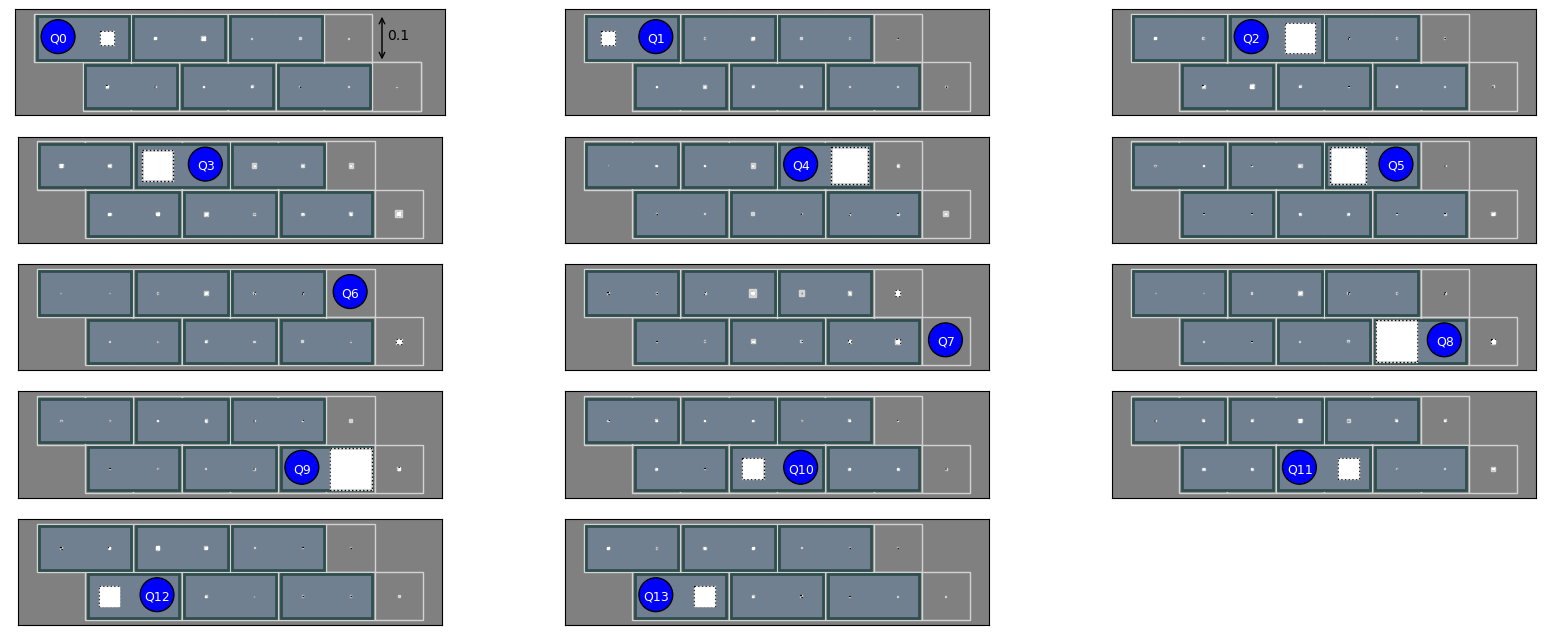

In [23]:
fig = figure("Slightly larger",figsize=(20,8))
mutualPsVer1 = [[mutualInformation(q,i,ppsVersion1) for q in 1:14] for i in 1:14];
#qbs = [[0,1],[2,3],[5,6],[8,7],[10,9],[13,12]]
set1 = [[0,1],[2,3],[13,12],[4,5],[11,10],[9,8]]
set2 = [[0,1],[2,3],[13,12],[4,10],[5,9],[6,8]]
set3 = [[1,2],[3,4],[5,6],[11,12],[9,10],[8,7]]



for i =1:14
    subplot(5,3,i)
    hinton(translate_14Q_Location(mutualPsVer1[i]',1),0.1,gca(),
        errorsL=translate_14Q_Location(map(x->x[1],boostrap2QMIInd[i])',1),
        errorsH=translate_14Q_Location(map(x->x[2],boostrap2QMIInd[i])',1),
        highlightNegative=true,qubit=9,fontsize=9,qubitPairs=set1,addScale=i==1)

end
#PyPlot.savefig("./SavedPDFs/TwoQubitMIVersion1_Ind_1Sigma.pdf", bbox_inches = "tight", pad_inches = 0)
#PyPlot.savefig("./SavedPNGs/TwoQubitMIVersion1_Ind_1Sigma.png", bbox_inches = "tight", pad_inches = 0)



### We can look at one of the qubits in particular if we want

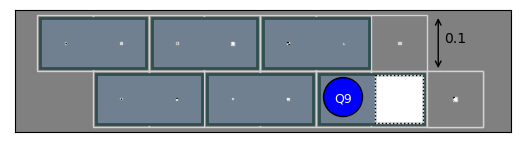

In [24]:
i=10
hinton(translate_14Q_Location(mutualPsVer1[i]',1),0.1,gca(),
        errorsH=translate_14Q_Location(map(x->x[2],boostrap2QMIInd[i])',1),
        errorsL=translate_14Q_Location(map(x->x[1],boostrap2QMIInd[i])',1),
        highlightNegative=true,qubit=9,fontsize=9,qubitPairs=set1,addScale=true)
#PyPlot.savefig("./SavedPDFs/TwoQubitMIQubit9Set1_1Sigma.pdf", bbox_inches = "tight", pad_inches = 0)

## Run 2

Same thing but different twirl layout.

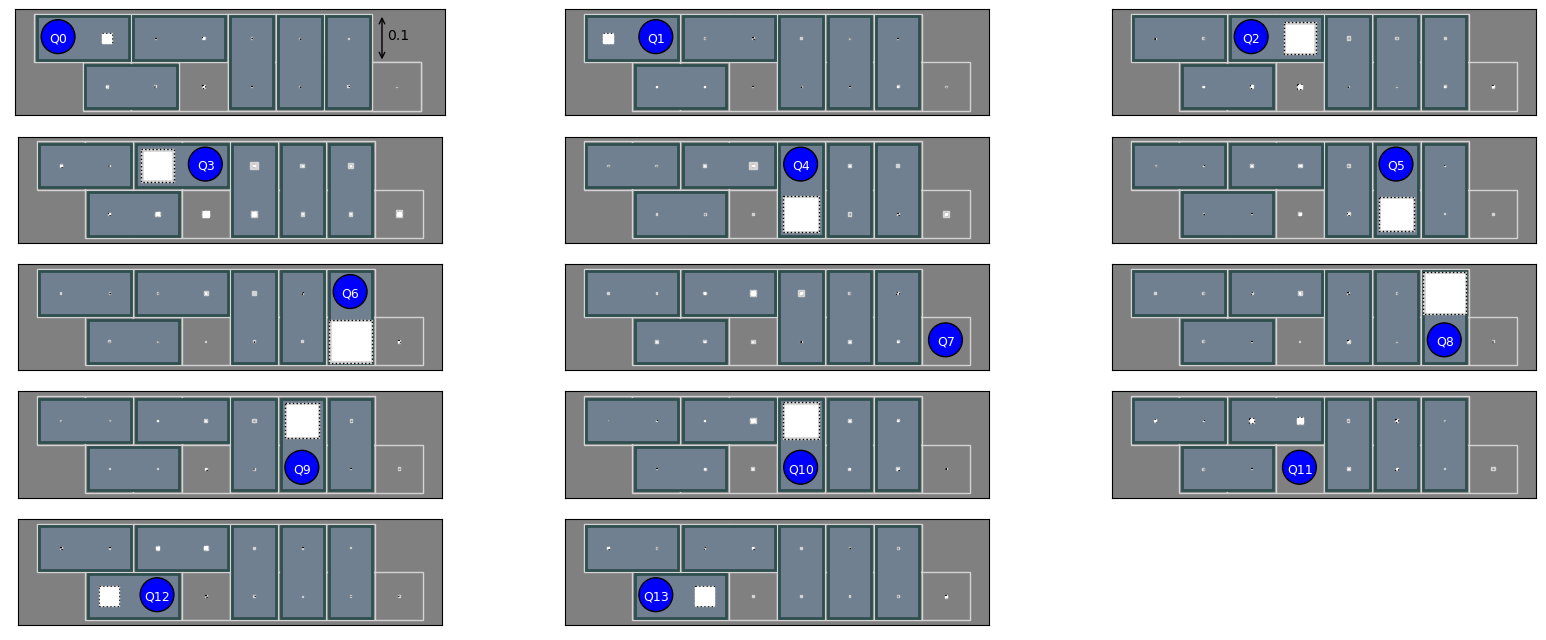

In [25]:
fig = figure("Slightly larger",figsize=(20,8))
mutualPsVer2 = [[mutualInformation(q,i,ppsVersion2) for q in 1:14] for i in 1:14];
#qbs = [[0,1],[2,3],[5,6],[8,7],[10,9],[13,12]]
set1 = [[0,1],[2,3],[13,12],[4,5],[11,10],[9,8]]
set2 = [[0,1],[2,3],[13,12],[4,10],[5,9],[6,8]]
set3 = [[1,2],[3,4],[5,6],[11,12],[9,10],[8,7]]



for i =1:14
    subplot(5,3,i)
    hinton(translate_14Q_Location(mutualPsVer2[i]',1),0.1,gca(),
        errorsH=translate_14Q_Location(map(x->x[2],boostrap2QMIInd2[i])',1),
        errorsL=translate_14Q_Location(map(x->x[1],boostrap2QMIInd2[i])',1),
        highlightNegative=true,qubit=9,fontsize=9,qubitPairs=set2,addScale=i==1)

end
#PyPlot.savefig("./SavedPDFs/TwoQubitMIVersion1_Ind_1Sigma.pdf", bbox_inches = "tight", pad_inches = 0)
#PyPlot.savefig("./SavedPNGs/TwoQubitMIVersion1_Ind_1Sigma.png", bbox_inches = "tight", pad_inches = 0)




## Run 3

This was the final different layout I tried.

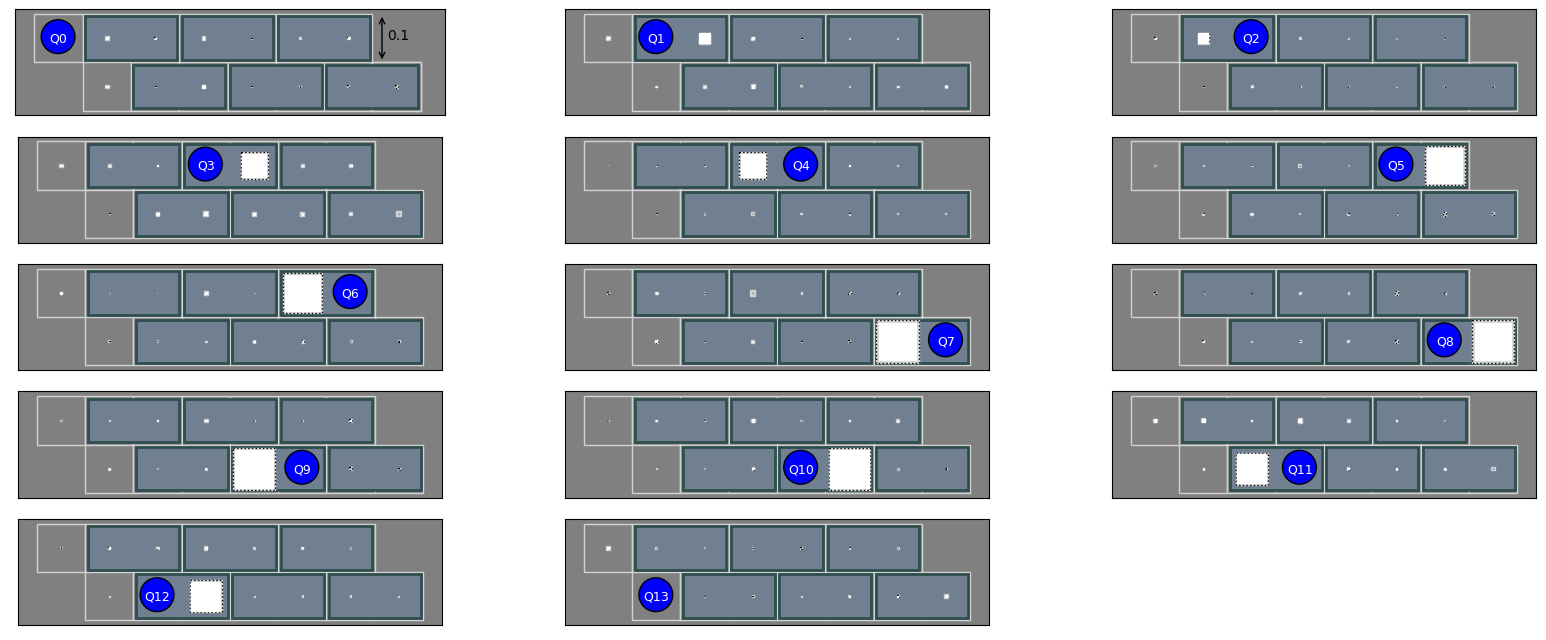

In [26]:
fig = figure("Slightly larger",figsize=(20,8))
mutualPsVer3 = [[mutualInformation(q,i,ppsVersion3) for q in 1:14] for i in 1:14];
#qbs = [[0,1],[2,3],[5,6],[8,7],[10,9],[13,12]]
set1 = [[0,1],[2,3],[13,12],[4,5],[11,10],[9,8]]
set2 = [[0,1],[2,3],[13,12],[4,10],[5,9],[6,8]]
set3 = [[1,2],[3,4],[5,6],[12,11],[10,9],[8,7]]

rset1 = [[1,2],[3,4],[14,13],[5,6],[12,11],[10,9],7,8]
rset2 = [[1,2],[3,4],[14,13],[5,11],[6,10],[7,9],12,8]
rset3 = [[2,3],[4,5],[6,7],[12,13],[10,11],[9,8],14,1]


for i =1:14
    subplot(5,3,i)
    hinton(translate_14Q_Location(mutualPsVer3[i]',1),0.1,gca(),
        errorsH=translate_14Q_Location(map(x->x[2],boostrap2QMIInd3[i])',1),
        errorsL=translate_14Q_Location(map(x->x[1],boostrap2QMIInd3[i])',1),
        highlightNegative=true,qubit=9,fontsize=9,qubitPairs=set3,addScale=i==1)

end
#PyPlot.savefig("./SavedPDFs/TwoQubitMIVersion1_Ind_1Sigma.pdf", bbox_inches = "tight", pad_inches = 0)
#PyPlot.savefig("./SavedPNGs/TwoQubitMIVersion1_Ind_1Sigma.png", bbox_inches = "tight", pad_inches = 0)



## Limited the number shown, just to make the plots bigger (for presentation)

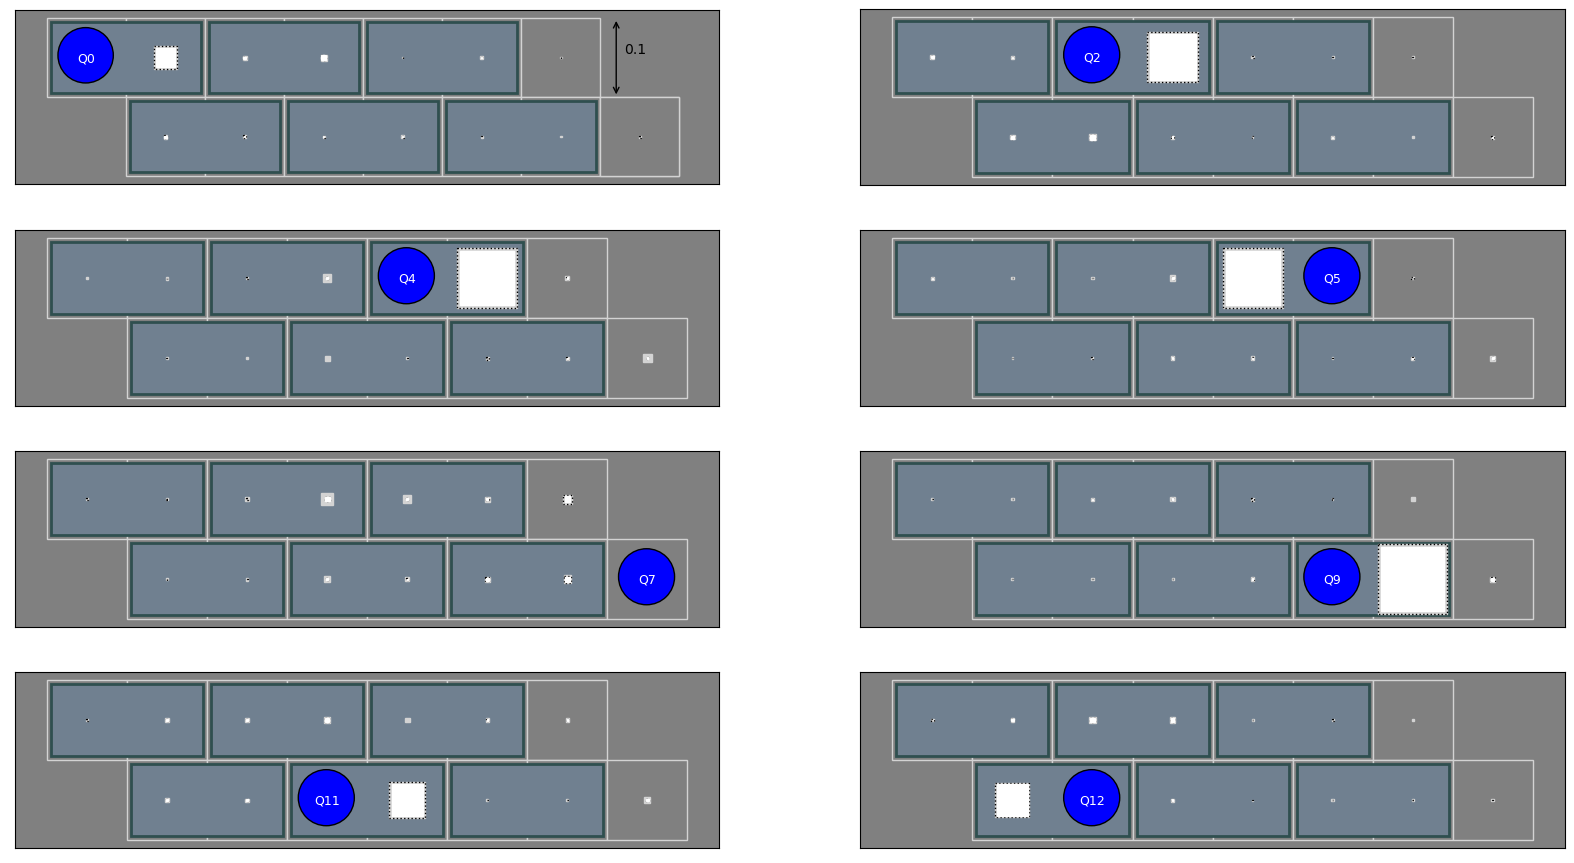

In [27]:
fig = figure("Slightly larger",figsize=(20,11))

rqbs = [[1,2],[3,4],[5],[6,7],[8,9],[10,11],12,[13,14]]
toShow = [1,3,5,6,8,10,12,13]
mutualPsVer1All = [[mutualInformation(q,i,ppsVersion1) for q in 1:14] for i in 1:14];

for (idx,i) in enumerate(toShow)
    subplot(4,2,idx)
    hinton(translate_14Q_Location(mutualPsVer1All[i]',1),0.1,gca(),
        errorsH=translate_14Q_Location(map(x->x[2],boostrap2QMIInd[i])',1),
        errorsL=translate_14Q_Location(map(x->x[1],boostrap2QMIInd[i])',1),
        highlightNegative=true,qubit=9,fontsize=9,qubitPairs=set1,addScale=i==1)

end
#PyPlot.savefig("./SavedPDFs/TwoQubitMIVersion1_Ind_LimShow_1Sigma.pdf", bbox_inches = "tight", pad_inches = 0)
#PyPlot.savefig("./SavedPNGs/TwoQubitMIVersion1_Ind_LimShow_1Sigma.png", bbox_inches = "tight", pad_inches = 0)




# Mutual Information between "Pairs" and other qubits

The idea here is that the large mutual information between a qubit and its 'pair' in the two qubit Clifford twirl, hides the fine grained detail we are really interested in which is the leakage of information (e.g. crosstalk) between that pair and the other pairs which are supposed to be independent.

So we can treat each pair as a single random variable and look at the mutual information between that pair and each of the other qubits.

## Calculate the data

In [28]:
set1 = [[0,1],[2,3],[13,12],[4,5],[11,10],[9,8]]
set2 = [[0,1],[2,3],[13,12],[4,10],[5,9],[6,8]]
set3 = [[1,2],[3,4],[5,6],[12,11],[10,9],[8,7]]

rset1 = [[1,2],[3,4],[14,13],[5,6],[12,11],[10,9],7,8]
rset2 = [[1,2],[3,4],[14,13],[5,11],[6,10],[7,9],12,8]
rset3 = [[2,3],[4,5],[6,7],[12,13],[10,11],[9,8],14,1]


all2QMI = []
p=Progress(1000)

for (idx,x) in enumerate(thousand2QPps1)
   push!(all2QMI,[[mutualInformation(q,j,x) for q in 1:14] for j in rset1]);
   next!(p)
end
bootstrap2QMI1=[[extractEnds(sort(map(x->x[a][b],all2QMI)),low=159,high=841) for b=1:14] for a in 1:8];

all2QMI = []
p=Progress(1000)

for (idx,x) in enumerate(thousand2QPps2)
   push!(all2QMI,[[mutualInformation(q,j,x) for q in 1:14] for j in rset2]);
   next!(p)
end
bootstrap2QMI2=[[extractEnds(sort(map(x->x[a][b],all2QMI)),low=159,high=841) for b=1:14] for a in 1:8];


all2QMI = []
p=Progress(1000)

for (idx,x) in enumerate(thousand2QPps3)
   push!(all2QMI,[[mutualInformation(q,j,x) for q in 1:14] for j in rset3]);
   next!(p)
end
bootstrap2QMI3=[[extractEnds(sort(map(x->x[a][b],all2QMI)),low=159,high=841) for b=1:14] for a in 1:8];





Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


## Plot run1

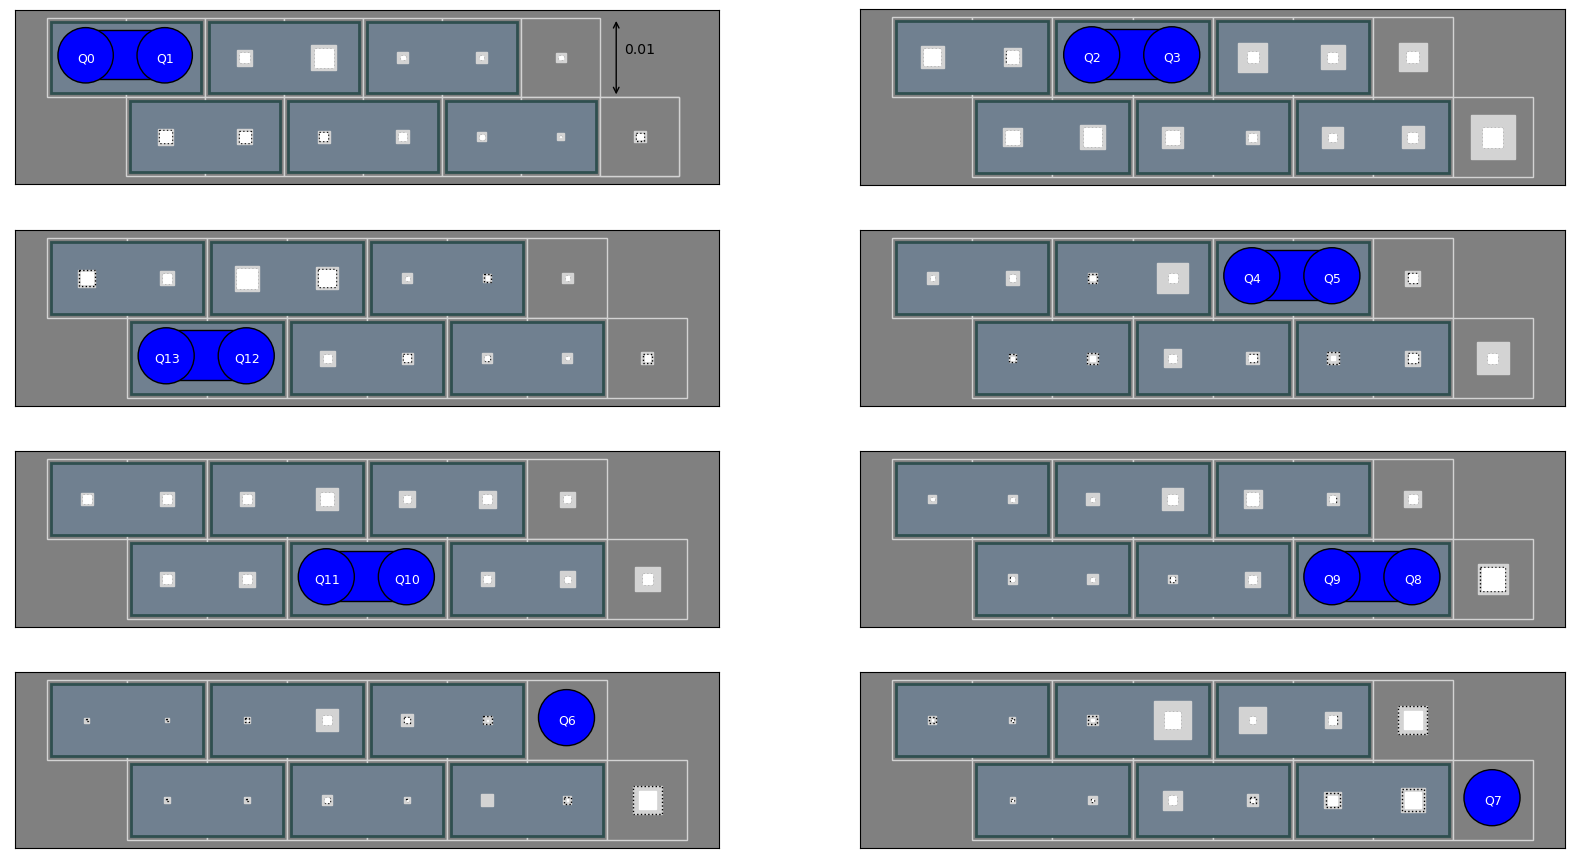

In [29]:
fig = figure("Slightly larger",figsize=(20,11))
mutualPsN1 = [[mutualInformation(q,i,ppsVersion1) for q in 1:14] for i in rset1];
for i =1:8
    subplot(4,2,i)
    hinton(translate_14Q_Location(mutualPsN1[i]',1),0.01,gca(),
        errorsH=translate_14Q_Location(map(x->x[2],bootstrap2QMI1[i])',1),
        errorsL=translate_14Q_Location(map(x->x[1],bootstrap2QMI1[i])',1),
        highlightNegative=true,qubit=9,fontsize=9,qubitPairs=set1,addScale=i==1)

end
#PyPlot.savefig("./SavedPDFs/TwoQubitIntVersion1_1Sigma_C.pdf", bbox_inches = "tight", pad_inches = 0)
#PyPlot.savefig("./SavedPNGs/TwoQubitIntVersion1_1Sigma_C.png", bbox_inches = "tight", pad_inches = 0)



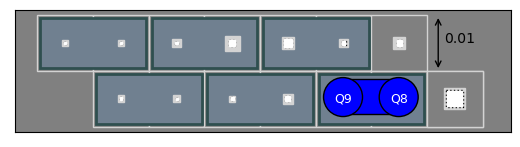

In [30]:

i=6
hinton(translate_14Q_Location(mutualPsN1[i]',1),0.01,gca(),
        errorsH=translate_14Q_Location(map(x->x[2],bootstrap2QMI1[i])',1),
        errorsL=translate_14Q_Location(map(x->x[1],bootstrap2QMI1[i])',1),
        highlightNegative=true,qubit=9,fontsize=9,qubitPairs=set1,addScale=true)


#PyPlot.savefig("./SavedPDFs/TwoQubitMIMarginalQubit9Set1_1Sigma.pdf", bbox_inches = "tight", pad_inches = 0)

## Plot run2

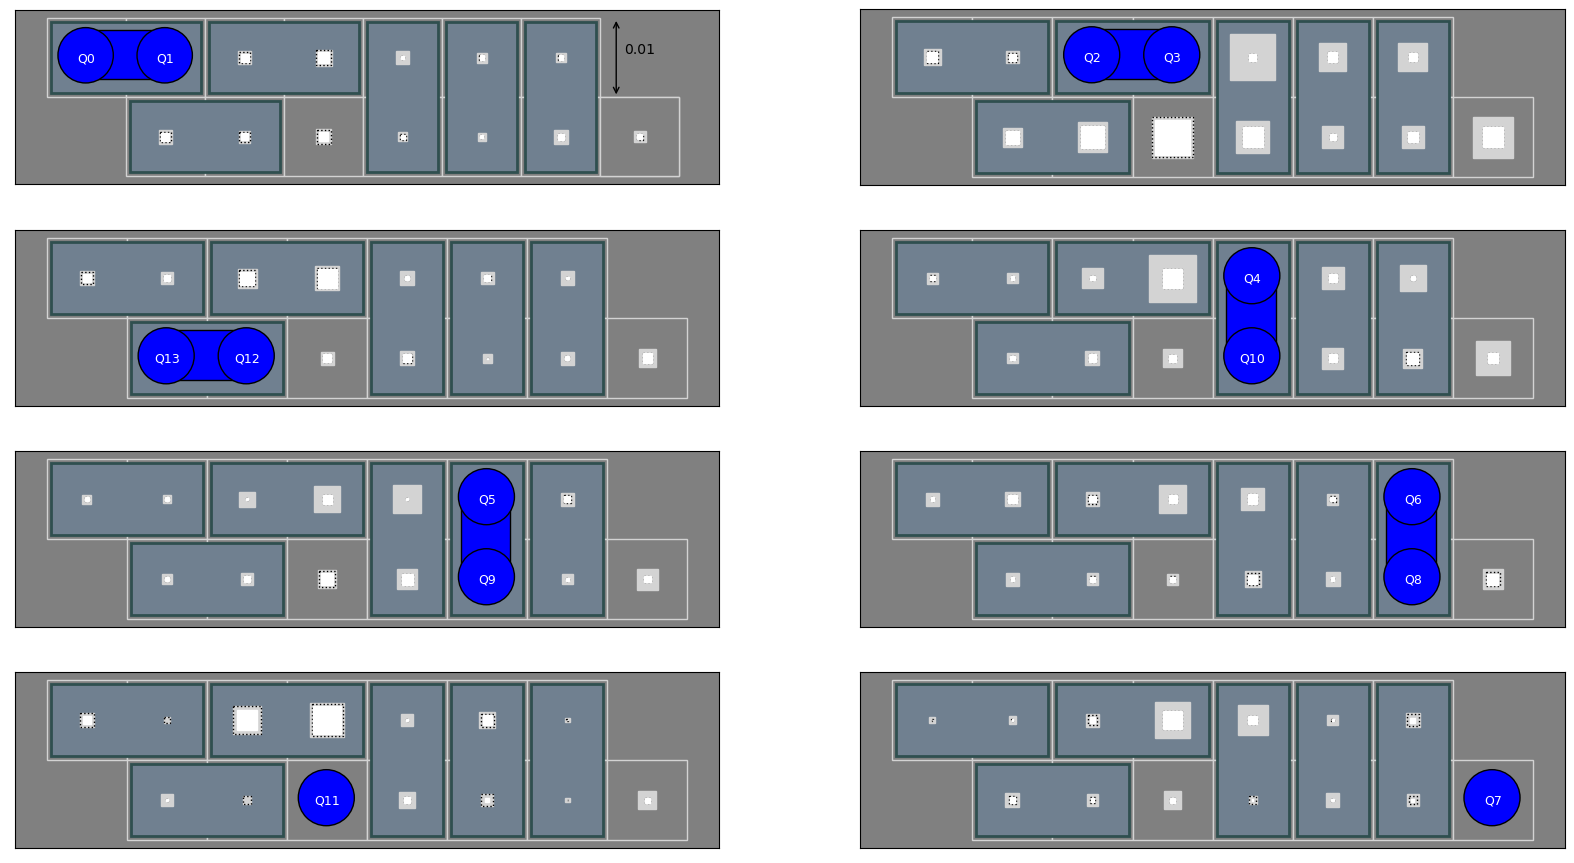

In [31]:
fig = figure("Slightly larger",figsize=(20,11))
mutualPsN2 = [[mutualInformation(q,i,ppsVersion2) for q in 1:14] for i in rset2];

for i =1:8
    subplot(4,2,i)
    hinton(translate_14Q_Location(mutualPsN2[i]',1), 0.01,gca(),
        errorsH=translate_14Q_Location(map(x->x[2],bootstrap2QMI2[i])',1),
        errorsL=translate_14Q_Location(map(x->x[1],bootstrap2QMI2[i])',1),
        highlightNegative=true,qubit=9,fontsize=9,qubitPairs=set2,addScale=i==1)

end
#PyPlot.savefig("./SavedPDFs/TwoQubitIntVersion2_1Sigma_C.pdf", bbox_inches = "tight", pad_inches = 0)
#PyPlot.savefig("./SavedPNGs/TwoQubitIntVersion2_1Sigma_C.png", bbox_inches = "tight", pad_inches = 0)




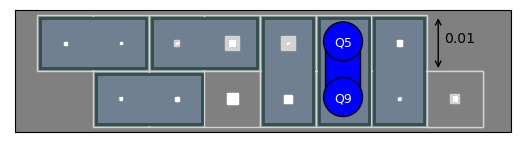

In [32]:

i=5
 hinton(translate_14Q_Location(mutualPsN2[i]',1),0.01,gca(),
        errorsL=translate_14Q_Location(map(x->x[2],bootstrap2QMI2[i])',1),
        errorsH=translate_14Q_Location(map(x->x[1],bootstrap2QMI2[i])',1),
        highlightNegative=true,qubit=9,fontsize=9,qubitPairs=set2,addScale=true)


#PyPlot.savefig("./SavedPDFs/TwoQubitMIMarginalQubit9Set2_1Sigma.pdf", bbox_inches = "tight", pad_inches = 0)

## Plot run3

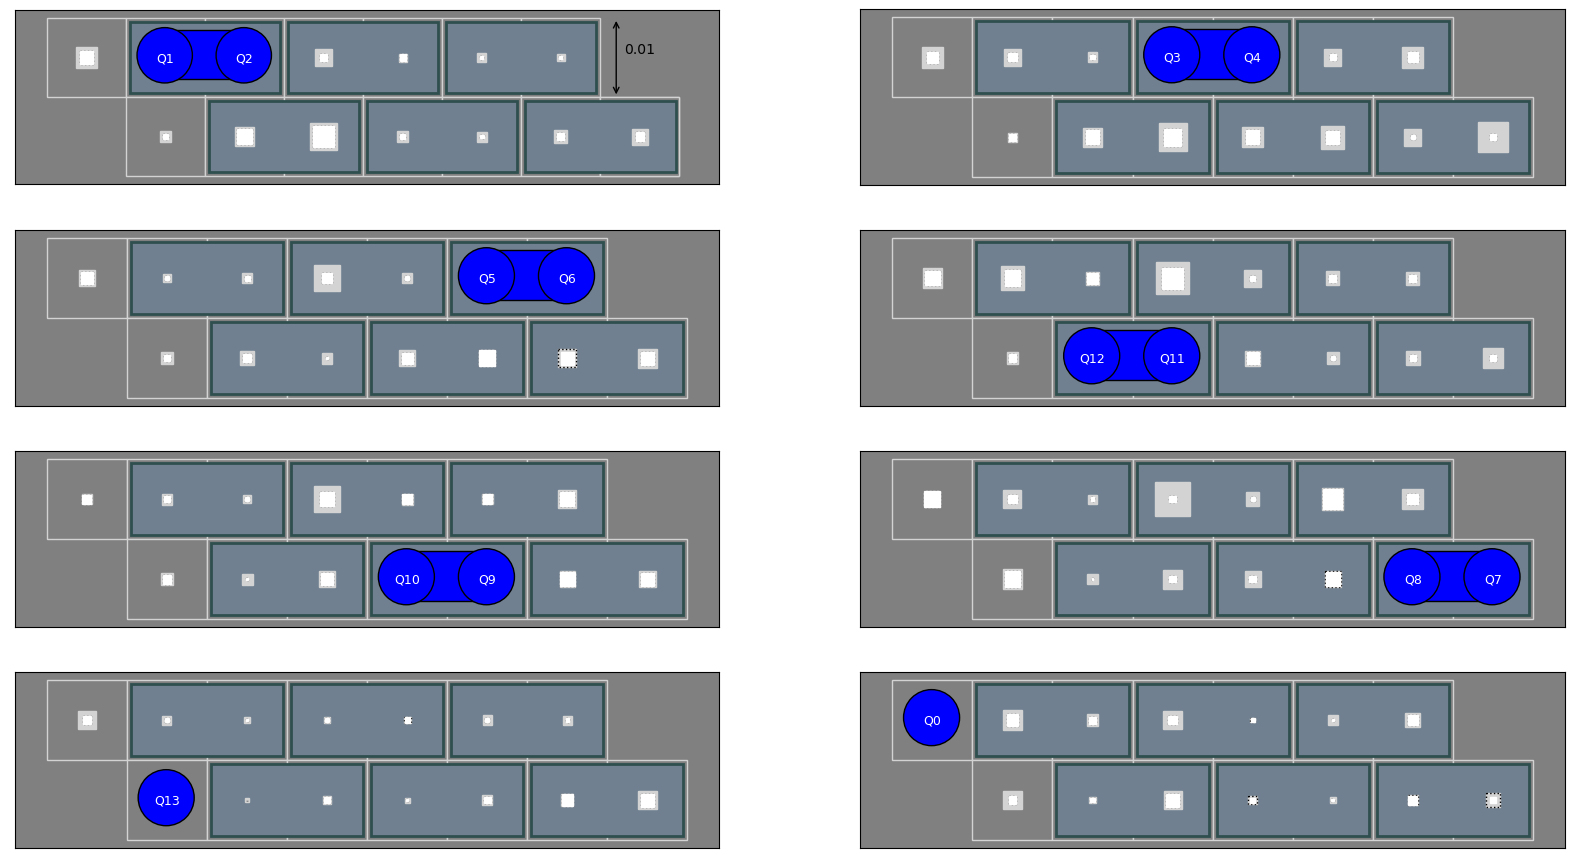

In [33]:
fig = figure("Slightly larger",figsize=(20,11))
mutualPsN3 = [[mutualInformation(q,i,ppsVersion3) for q in 1:14] for i in rset3];

for i =1:8
    subplot(4,2,i)
    hinton(translate_14Q_Location(mutualPsN3[i]',1),0.01,gca(),
        errorsH=translate_14Q_Location(map(x->x[2],bootstrap2QMI3[i])',1),
        errorsL=translate_14Q_Location(map(x->x[2],bootstrap2QMI3[i])',1),
        highlightNegative=true,qubit=9,fontsize=9,qubitPairs=set3,addScale=i==1)

end
#PyPlot.savefig("./SavedPDFs/TwoQubitIntVersion3_1Sigma_C.pdf", bbox_inches = "tight", pad_inches = 0)
#PyPlot.savefig("./SavedPNGs/TwoQubitIntVersion3_1Sigma_C.png", bbox_inches = "tight", pad_inches = 0)




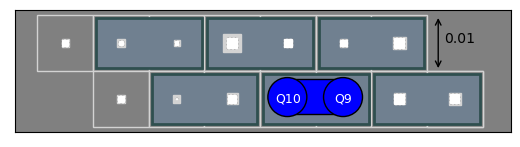

In [34]:

i=5
hinton(translate_14Q_Location(mutualPsN3[i]',1),0.01,gca(),
        errorsH=translate_14Q_Location(map(x->x[2],bootstrap2QMI3[i])',1),
        errorsL=translate_14Q_Location(map(x->x[2],bootstrap2QMI3[i])',1),
        highlightNegative=true,qubit=9,fontsize=9,qubitPairs=set3,addScale=true)


#PyPlot.savefig("./SavedPDFs/TwoQubitMIMarginalQubit9Set3_1Sigma.pdf", bbox_inches = "tight", pad_inches = 0)

# Correlation Matrices

## calculate the data

In [35]:
corrmat1= correlationMatrix(ppsVersion1);
corrmat2= correlationMatrix(ppsVersion2);
corrmat3= correlationMatrix(ppsVersion3);


In [36]:
bootCorr = @showprogress [correlationMatrix(x) for x in thousand2QPps1];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


In [37]:
bootstrapCorr1=[[extractEnds(sort(map(x->x[a,b],bootCorr)),low=159,high=841) for b in 1:14] for a in 1:14];

In [38]:
highCorrSingle1 = [extractEnds(sort(map(x->x[b,a],bootCorr)),low=159,high=841)[2] for a in 1:14, b in 1:14]
lowCorrSingle1 = [extractEnds(sort(map(x->x[b,a],bootCorr)),low=159,high=841)[1] for a in 1:14, b in 1:14];

In [39]:
# This will take a few minutes
bootCorr = @showprogress [correlationMatrix(x) for x in thousand2QPps2]
highCorrSingle2 = [extractEnds(sort(map(x->x[b,a],bootCorr)),low=159,high=841)[2] for a in 1:14, b in 1:14]
lowCorrSingle2 = [extractEnds(sort(map(x->x[b,a],bootCorr)),low=159,high=841)[1] for a in 1:14, b in 1:14];
bootCorr = @showprogress [correlationMatrix(x) for x in thousand2QPps3]
highCorrSingle3 = [extractEnds(sort(map(x->x[b,a],bootCorr)),low=159,high=841)[2] for a in 1:14, b in 1:14]
lowCorrSingle3 = [extractEnds(sort(map(x->x[b,a],bootCorr)),low=159,high=841)[1] for a in 1:14, b in 1:14];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24
Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


### Set up the qubits that participate in each two qubit twirl, in a form we can draw boxes around them

In [40]:
draw1=[[0,1],[2,3],[12,13],[4,5],[10,11],[8,9]]
draw2 = [[0,1],[2,3],[12,13],[4,10],[5,9],[6,8]]
draw3 = [[1,2],[3,4],[5,6],[11,12],[9,10],[7,8]]

6-element Vector{Vector{Int64}}:
 [1, 2]
 [3, 4]
 [5, 6]
 [11, 12]
 [9, 10]
 [7, 8]

## Correlation matrix for run1

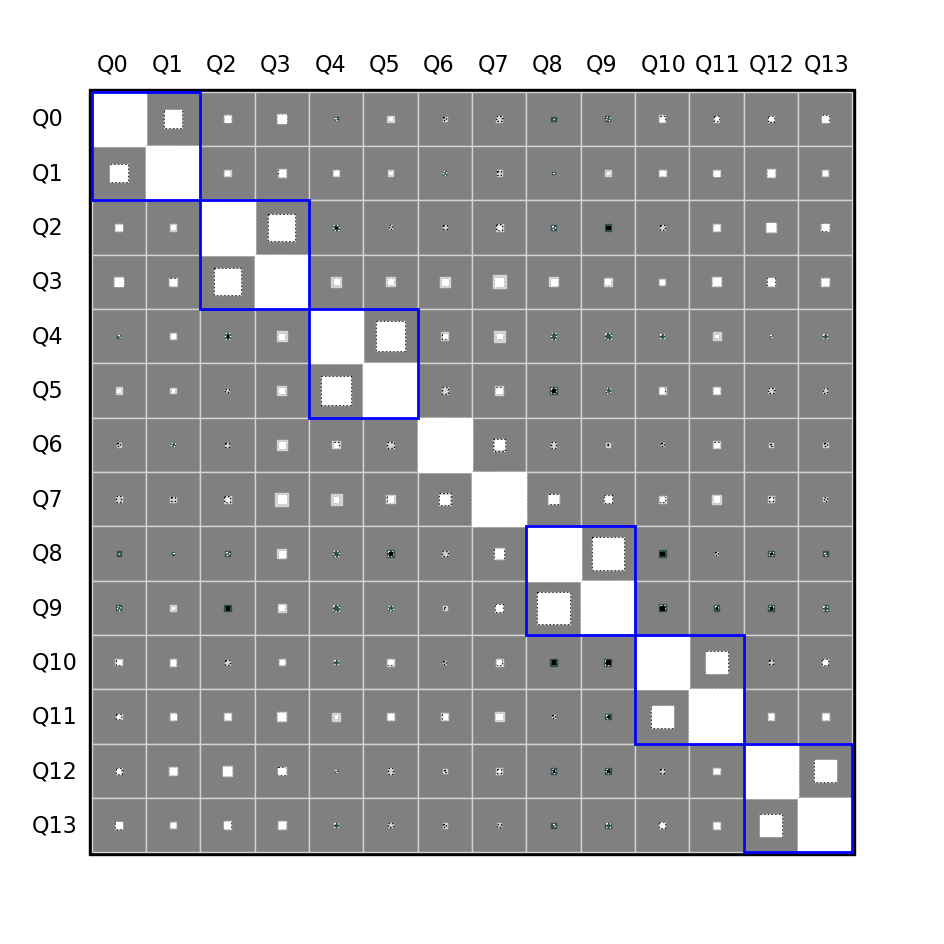

In [41]:
fig = figure("Slightly larger",figsize=(12,12))
ax=gca()
covhinton(corrmat1,1,ax,
            highCorr=highCorrSingle1,
            lowCorr=lowCorrSingle1,
            addAxis=true,adjust=0.6,addOneAxis=true,
            stagger=false,voffset=0.4,fontsize=16)
for x in draw1
    rect = plt.Rectangle([x[1]+1.5,x[1]+1.5], 2, 2, facecolor="none",edgecolor="blue",linewidth=2)
    ax.add_patch(rect)
end
#PyPlot.savefig("./SavedPDFs/CmatrixTwoQubitIntVersion1_1Sigma_C.pdf", bbox_inches = "tight", pad_inches = 0)
#PyPlot.savefig("./SavedPNGs/CmatrixTwoQubitIntVersion1_1Sigma_C.png", bbox_inches = "tight", pad_inches = 0)





## Correlation matrix for run2

Note the layout here means we can't draw the 'blue' boxes if we keep the qubits in their numerical order (see later)

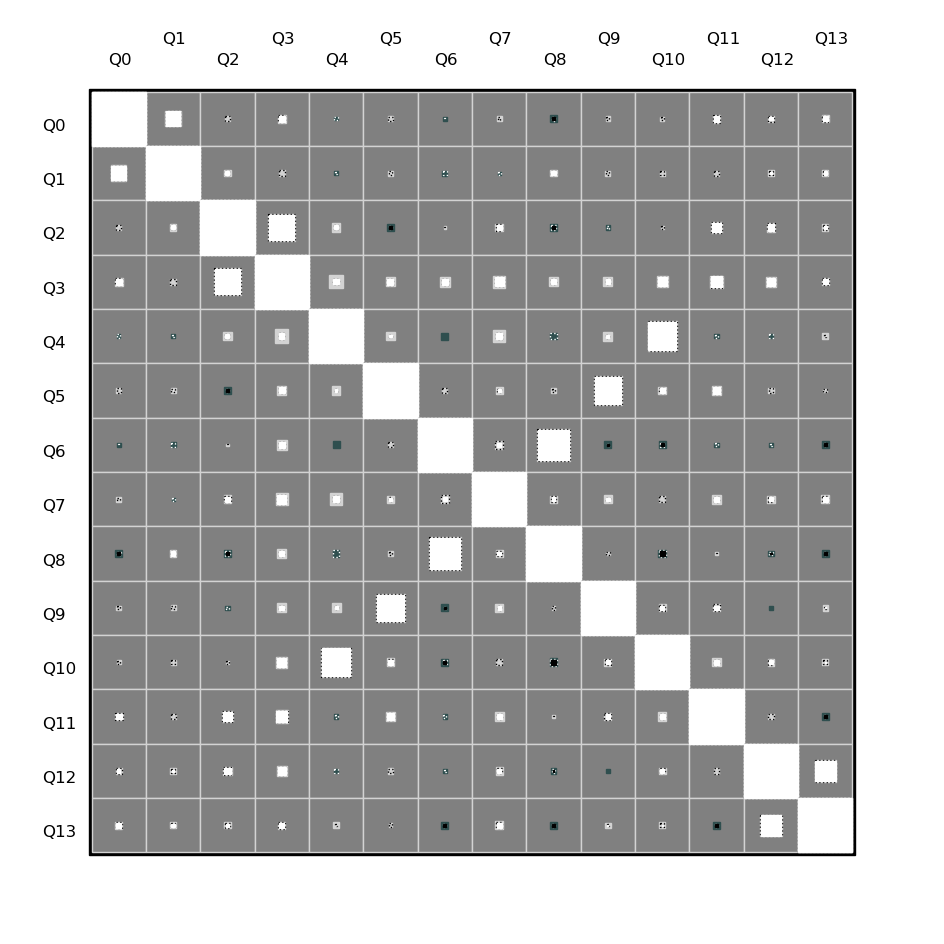

In [42]:
fig = figure("Slightly larger",figsize=(12,12))
ax=gca()
covhinton(corrmat2,1,ax,
    highCorr=highCorrSingle2,
    lowCorr=lowCorrSingle2,
    addAxis=true,adjust=0.8,addOneAxis=true)

#PyPlot.savefig("./SavedPDFs/CmatrixTwoQubitIntVersion2_1Sigma_C.pdf", bbox_inches = "tight", pad_inches = 0)
#PyPlot.savefig("./SavedPNGs/CmatrixTwoQubitIntVersion2_1Sigma_C.png", bbox_inches = "tight", pad_inches = 0)



### Re-order the display qubits in the correlation matrix (Run 2)

The idea here is we want the correlation matrix to place qubits that participated in the same twirl next to each other

First some code


In [43]:
#cvrset2 = [[1,2],[3,4],[5,11],[6,10],[7,9],[8],[12],[13,14]]

function swapRowsAndColumns!(matrix,index,q1,q2)
    temp = matrix[q1,:]
    matrix[q1,:] = matrix[q2,:]
    matrix[q2,:] = temp
    temp = matrix[:,q1]
    matrix[:,q1] = matrix[:,q2]
    matrix[:,q2] = temp
    t = index[q1]
    index[q1]=index[q2]
    index[q2]=t
end

swapRowsAndColumns! (generic function with 1 method)

In [44]:

ind = [i for i=0:13]
xind = [i for i=0:13]
swapsies = [(6,11),(7,11),(8,10),(9,11),(10,11)]
corrmatV2_Reorder = copy(corrmat2)
highCorrV2_Reorder = copy(highCorrSingle2)
lowCorrV2_Reorder = copy(lowCorrSingle2)

for (a,b) in swapsies
    swapRowsAndColumns!(corrmatV2_Reorder,ind,a,b)
    swapRowsAndColumns!(highCorrV2_Reorder,ind,a,b)
    swapRowsAndColumns!(lowCorrV2_Reorder,ind,a,b)
end
    

print(ind)



[0, 1, 2, 3, 4, 10, 5, 9, 6, 8, 7, 11, 12, 13]

### Re-ordered correlation matrix (Run 2)

Note the order of the qubits - not sequential

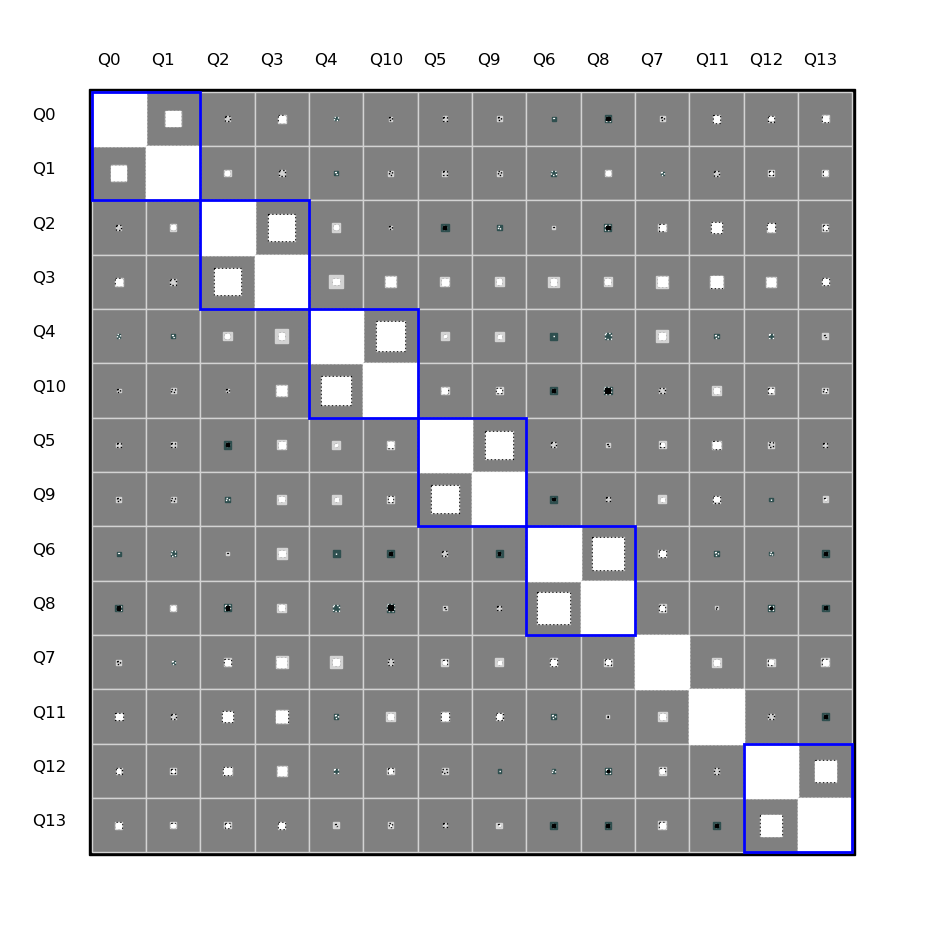

In [45]:
fig = figure("Slightly larger",figsize=(12,12))
ax=gca()
covhinton(corrmatV2_Reorder,1,ax,
    highCorr=highCorrV2_Reorder,
    lowCorr=lowCorrV2_Reorder,
    addAxis=true,adjust=0.6,
    voffset=0.4,addOneAxis=true,ind=ind,stagger=false)

for x in [[0,1],[2,3],[4,5],[6,7],[8,9],[12,13]]
    rect = plt.Rectangle([x[1]+1.5,x[1]+1.5], 2, 2, facecolor="none",edgecolor="blue",linewidth=2)
    ax.add_patch(rect)
end

#PyPlot.savefig("./SavedPDFs/CmatrixTwoQubitIntVersion2_1Sigma_C.pdf", bbox_inches = "tight", pad_inches = 0)
#PyPlot.savefig("./SavedPNGs/CmatrixTwoQubitIntVersion2_1Sigma_C.png", bbox_inches = "tight", pad_inches = 0)



## Correlation matrix - Run 3

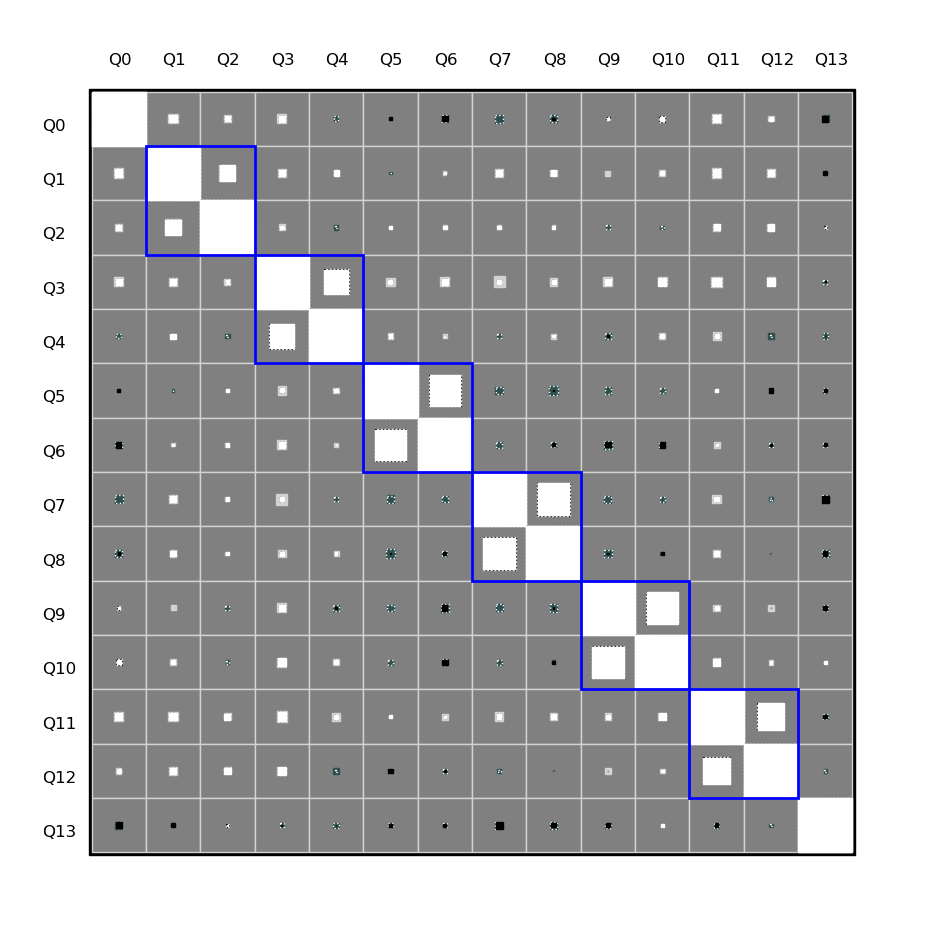

In [46]:
fig = figure("Slightly larger",figsize=(12,12))
ax=gca()
covhinton(corrmat3,1,ax,
    highCorr=highCorrSingle3,
    lowCorr=highCorrSingle3,
    addAxis=true,adjust=0.8,addOneAxis=true,
            stagger=false,voffset=0.4)

for x in draw3
    rect = plt.Rectangle([x[1]+1.5,x[1]+1.5], 2, 2, facecolor="none",edgecolor="blue",linewidth=2)
    ax.add_patch(rect)
end
#PyPlot.savefig("./SavedPDFs/CmatrixTwoQubitIntVersion3_1Sigma_C.pdf", bbox_inches = "tight", pad_inches = 0)
#PyPlot.savefig("./SavedPNGs/CmatrixTwoQubitIntVersion3_1Sigma_C.png", bbox_inches = "tight", pad_inches = 0)




# Reduced Correlation matrices

We can do a similar trick to the one we did with Mutual Information.

If we assume that each qubit pair is a single RV then we can recreate the correlation matrix as between these RVs. This might be helpful in pulling out unwanted/unexpected correlations.

## Do the calcualtion

In [47]:
function averageCorrelationMatrix(matrix,rqbs)
    avCorrmat = zeros(8,8)
    for (ix,x) in enumerate(rqbs)
        for (iy,y) in enumerate(rqbs)
            if x== y
                avCorrmat[ix,iy]=1
            else
                avCorrmat[ix,iy] = mean(matrix[x,y])
            end
        end
    end
    return avCorrmat
end

averageCorrelationMatrix (generic function with 1 method)

In [48]:
function reduceTheDimension(pMatrix,rqbs)
pvr = copy(pMatrix);
dimsToDo = reverse(map(x->2^length(x),rqbs));

pvr = reshape(pvr,dimsToDo...);
indexAt = length(dimsToDo)
fullLength = length(dimsToDo)
sumNeeded = false
for indexAt = 8:-1:1
    if dimsToDo[indexAt] == 4
        sumNeeded = true
    else
        sumNeeded = false
    end 
    dimsToDo[indexAt] = 2
    nvr = zeros(dimsToDo...)
    index1 = vcat([Colon() for _ = 1:(indexAt-1)],[1],[Colon() for _ = (indexAt+1):fullLength])
    index2 = vcat([Colon() for _ = 1:(indexAt-1)],[2],[Colon() for _ = (indexAt+1):fullLength])
    #index3 = vcat([Colon() for _ = 1:(indexAt-1)],[2:4],[Colon() for _ = (indexAt+1):fullLength])
    index3 = vcat([Colon() for _ = 1:(indexAt-1)],[[1,4]],[Colon() for _ = (indexAt+1):fullLength])
    index4 = vcat([Colon() for _ = 1:(indexAt-1)],[[2,3]],[Colon() for _ = (indexAt+1):fullLength])
   if sumNeeded == true
        newVR = zeros(dimsToDo...)
        newVR[index1...]= sum(pvr[index3...],dims=indexAt)
        newVR[index2...]= sum(pvr[index4...],dims=indexAt)
        # newVR[index2...]= sum(pvr[index3...],dims=indexAt)
        pvr = newVR
    end
end
return reshape(pvr,:)
end


reduceTheDimension (generic function with 1 method)

In [49]:
cvrset1 = [[1,2],[3,4],[5,6],[7],[8],[9,10],[11,12],[13,14]]
cvrset2 = [[1,2],[3,4],[5,11],[6,10],[7,9],[8],[12],[13,14]]
cvrset3 = [[1],[2,3],[4,5],[6,7],[8,9],[10,11],[12,13],[14]]

corrmatRV1 = correlationMatrix(reduceTheDimension(ppsVersion1,cvrset1));
corrmatsRV1 = [correlationMatrix(reduceTheDimension(x,cvrset1)) for x in thousand2QPps1];
highCorrRV1 = [extractEnds(sort(map(x->x[b,a],corrmatsRV1)),low=159,high=841)[2] for a in 1:8, b in 1:8]
lowCorrRV1 =  [extractEnds(sort(map(x->x[b,a],corrmatsRV1)),low=159,high=841)[1] for a in 1:8, b in 1:8];
corrmatRV2 = correlationMatrix(reduceTheDimension(ppsVersion2,cvrset2));
corrmatsRV2 = [correlationMatrix(reduceTheDimension(x,cvrset2)) for x in thousand2QPps2];
highCorrRV2 = [extractEnds(sort(map(x->x[b,a],corrmatsRV1)),low=159,high=841)[2] for a in 1:8, b in 1:8]
lowCorrRV2 =  [extractEnds(sort(map(x->x[b,a],corrmatsRV1)),low=159,high=841)[1] for a in 1:8, b in 1:8];
corrmatRV3 = correlationMatrix(reduceTheDimension(ppsVersion3,cvrset3));
corrmatsRV3 = [correlationMatrix(reduceTheDimension(x,cvrset3)) for x in thousand2QPps3];
highCorrRV3 = [extractEnds(sort(map(x->x[b,a],corrmatsRV1)),low=159,high=841)[2] for a in 1:8, b in 1:8]
lowCorrRV3 =  [extractEnds(sort(map(x->x[b,a],corrmatsRV1)),low=159,high=841)[1] for a in 1:8, b in 1:8];



## Display reduced correlation matrix, Run1

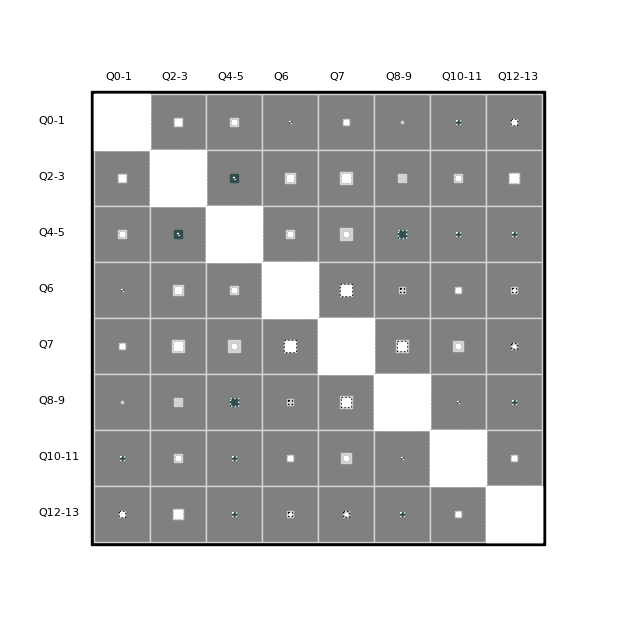

In [50]:
fig = figure("Slightly larger",figsize=(8,8))

#rset1 = [[1,2],[3,4],[14,13],[5,6],[12,11],[10,9],7,8]
#rset2 = [[1,2],[3,4],[14,13],[5,11],[6,10],[7,9],12,8]
#rset3 = [[2,3],[4,5],[6,7],[12,13],[10,11],[9,8],14,1]

covhinton(corrmatRV1,1,gca(),
    highCorr=highCorrRV1,
    lowCorr=lowCorrRV1,
    addAxis=true,adjust=.7,addOneAxis=true,fontsize=8,
             qlabels=["Q0-1","Q2-3","Q4-5","Q6","Q7","Q8-9","Q10-11","Q12-13"],stagger=false,voffset=0.7)

#PyPlot.savefig("./SavedPDFs/RCmatrixTwoQubitIntVersionR1_1Sigma_C.pdf", bbox_inches = "tight", pad_inches = 0)
#PyPlot.savefig("./SavedPNGs/RCmatrixTwoQubitIntVersionR1_1Sigma_C.png", bbox_inches = "tight", pad_inches = 0)



## Display reduced correlation matrix, Run2

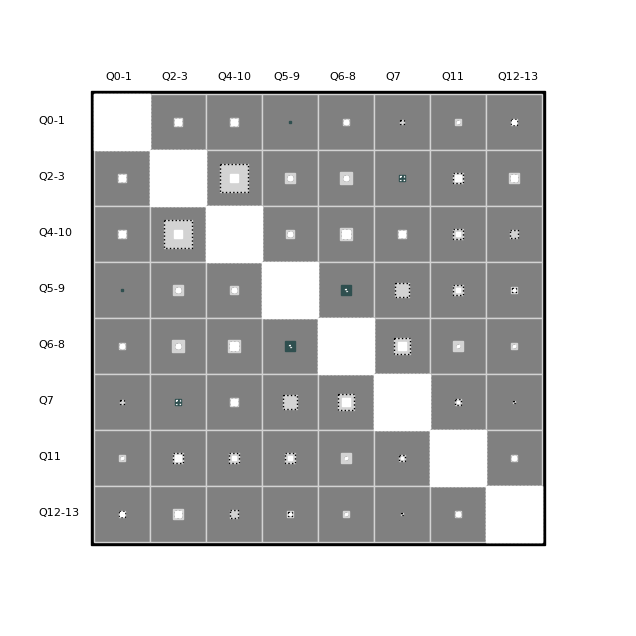

In [51]:
fig = figure("Slightly larger",figsize=(8,8))




covhinton(corrmatRV2,1,gca(),addAxis=true,adjust=0.7,
    highCorr=highCorrRV2,
    lowCorr=lowCorrRV2,
    addOneAxis=true,fontsize=8,
             qlabels=["Q0-1","Q2-3","Q4-10","Q5-9","Q6-8","Q7","Q11","Q12-13"],stagger=false,voffset=0.7)


#PyPlot.savefig("./SavedPDFs/RCmatrixTwoQubitIntVersionR2_1Sigma_C.pdf", bbox_inches = "tight", pad_inches = 0)
#PyPlot.savefig("./SavedPNGs/RCmatrixTwoQubitIntVersionR2_1Sigma_C.png", bbox_inches = "tight", pad_inches = 0)




## Display reduced correlation matrix, Run3

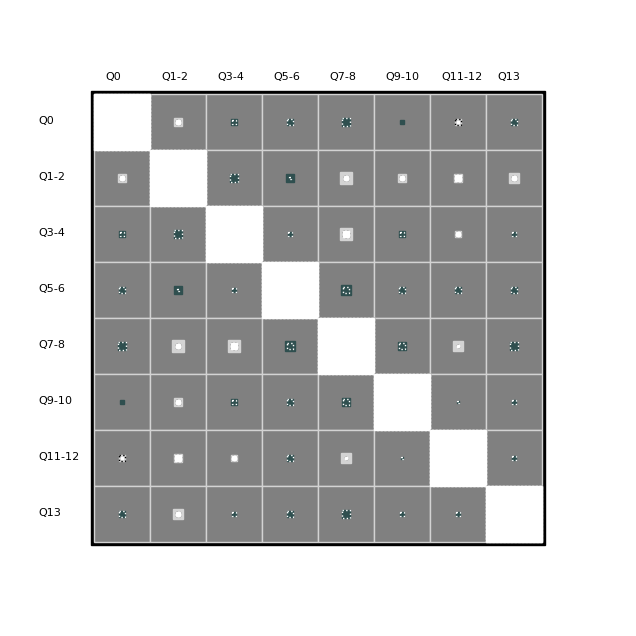

In [52]:
fig = figure("Slightly larger",figsize=(8,8))


covhinton(corrmatRV3,1,gca(),
    highCorr = highCorrRV3,lowCorr=lowCorrRV3,
    addAxis=true,adjust=0.7,addOneAxis=true,fontsize=8,
            qlabels=["Q0","Q1-2","Q3-4","Q5-6","Q7-8","Q9-10","Q11-12","Q13"],stagger=false,voffset=0.7)


#PyPlot.savefig("./SavedPDFs/RCmatrixTwoQubitIntVersionR3_1Sigma_C.pdf", bbox_inches = "tight", pad_inches = 0)
#PyPlot.savefig("./SavedPNGs/RCmatrixTwoQubitIntVersionR3_1Sigma_C.png", bbox_inches = "tight", pad_inches = 0)







## And all together in the one figure

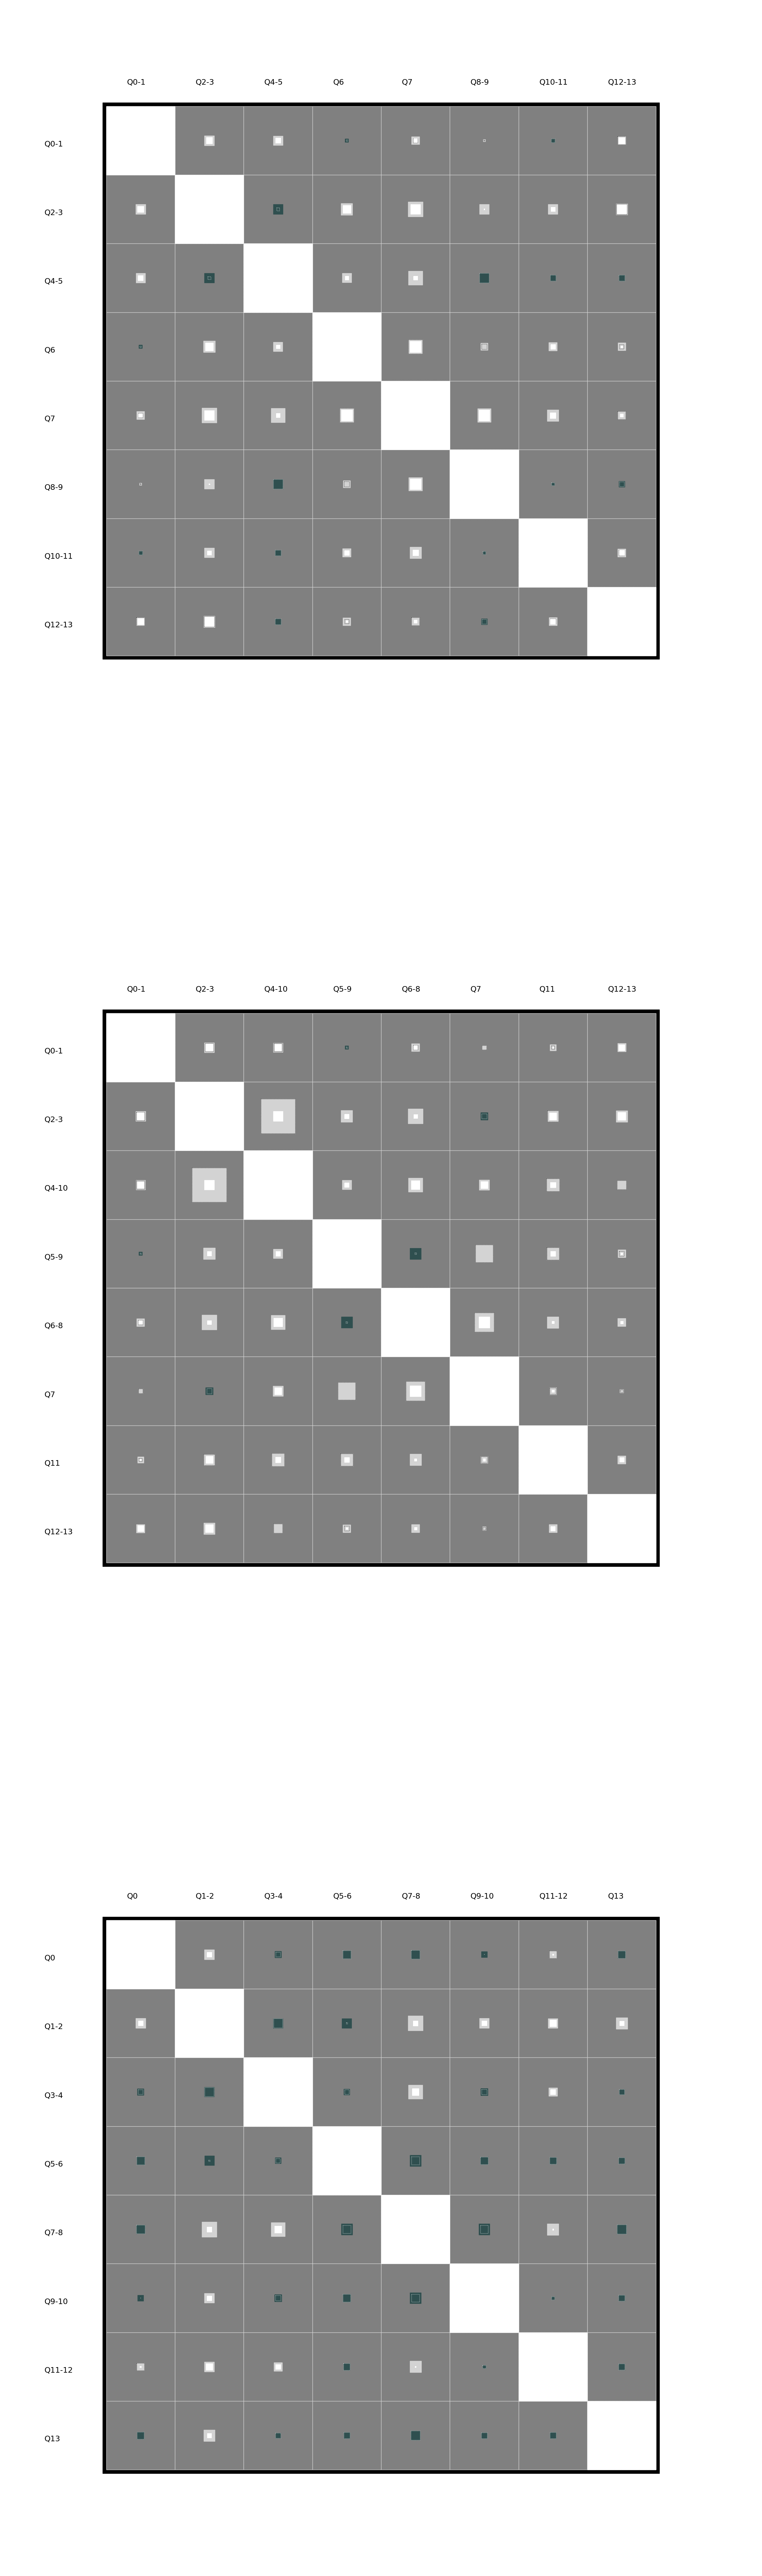

In [53]:
fig = figure("Slightly larger",figsize=(36,108))

#rset1 = [[1,2],[3,4],[14,13],[5,6],[12,11],[10,9],7,8]
#rset2 = [[1,2],[3,4],[14,13],[5,11],[6,10],[7,9],12,8]
#rset3 = [[2,3],[4,5],[6,7],[12,13],[10,11],[9,8],14,1]

subplot(3,1,1)
covhinton(corrmatRV1,1,gca(),
    highCorr=highCorrRV1,
    lowCorr=lowCorrRV1,
    addAxis=true,adjust=0.8,addOneAxis=true,fontsize=18,
            qlabels=["Q0-1","Q2-3","Q4-5","Q6","Q7","Q8-9","Q10-11","Q12-13"],stagger=false,voffset=0.7)
subplot(3,1,2)
covhinton(corrmatRV2,1,gca(),
    highCorr=highCorrRV2,
    lowCorr=lowCorrRV2,
    addAxis=true,adjust=0.8,addOneAxis=true,fontsize=18,
            qlabels=["Q0-1","Q2-3","Q4-10","Q5-9","Q6-8","Q7","Q11","Q12-13"],stagger=false,voffset=0.7)

subplot(3,1,3)
covhinton(corrmatRV3,1,gca(),
    highCorr=highCorrRV3,
    lowCorr=lowCorrRV3,
    addAxis=true,adjust=0.8,addOneAxis=true,fontsize=18,
            qlabels=["Q0","Q1-2","Q3-4","Q5-6","Q7-8","Q9-10","Q11-12","Q13"],stagger=false,voffset=0.7)


#PyPlot.savefig("./SavedPDFs/RCmatrixTwoQubitIntVersionR123_2Sigma_C.pdf", bbox_inches = "tight", pad_inches = 0)
#PyPlot.savefig("./SavedPNGs/RCmatrixTwoQubitIntVersionR123_2Sigma_C.png", bbox_inches = "tight", pad_inches = 0)




# Gibbs Random Fields and Markov Blankets


This is based on the following 'ansatz'

![grf](./grf.png)

Where qubits have been renumbered to account for Julia prefering 1-indexing.

The SingleQubitProtocol workbook goes through this in slightly more detail, here I just analyse

## Initial calculations and data

In [54]:
# These are the Markov blanket constraints we are using.
# This has now been updated to allow arbitrary constraints, but for this worksheet read this as:
# left to right, the 'give' or 'conditioned' on is the overlab between one list and the next one
# so this is p(1|2,14)p(2,14|13,3).. and so on.
constraints = [[1,2,14],[2,14,13,3],[13,3,4,12],[4,12,5,11],[5,11,6,10],[6,10,7,9],[7,9,8]]

7-element Vector{Vector{Int64}}:
 [1, 2, 14]
 [2, 14, 13, 3]
 [13, 3, 4, 12]
 [4, 12, 5, 11]
 [5, 11, 6, 10]
 [6, 10, 7, 9]
 [7, 9, 8]

### Below is a little sanity check that I get the same results whether I 'read' the graph left to right or right to left

In [55]:
# Just checking a graph is a graph is graph!
constraints2 = reverse.(reverse(constraints))

7-element Vector{Vector{Int64}}:
 [8, 9, 7]
 [9, 7, 10, 6]
 [10, 6, 11, 5]
 [11, 5, 12, 4]
 [12, 4, 3, 13]
 [3, 13, 14, 2]
 [14, 2, 1]

### Note the difference in these figures, from the ones we got on the single qubit run.

This ansatz is NOT sufficient to explain the noise going on when the two qubit gates are active.

In [56]:
print("JS Entropy, 1: $(sqrt(reconstructedJS(ppsVersion1,constraints))), \t$(sqrt(reconstructedJS(ppsVersion1,constraints2)))\n")
print("JS Entropy, 2: $(sqrt(reconstructedJS(ppsVersion2,constraints))), \t$(sqrt(reconstructedJS(ppsVersion2,constraints2)))\n")
print("JS Entropy, 3: $(sqrt(reconstructedJS(ppsVersion3,constraints))), \t$(sqrt(reconstructedJS(ppsVersion3,constraints2)))\n")

JS Entropy, 1: 0.21615790665257958, 	0.21615790665257956
JS Entropy, 2: 0.21754710024193105, 	0.21754710024193105
JS Entropy, 3: 0.21171675455828098, 	0.21171675455828098


## Plot the difference etc.

Some plots/figures with the actual distribution on one half and the reconstructed distribution on the other.

### Run 1

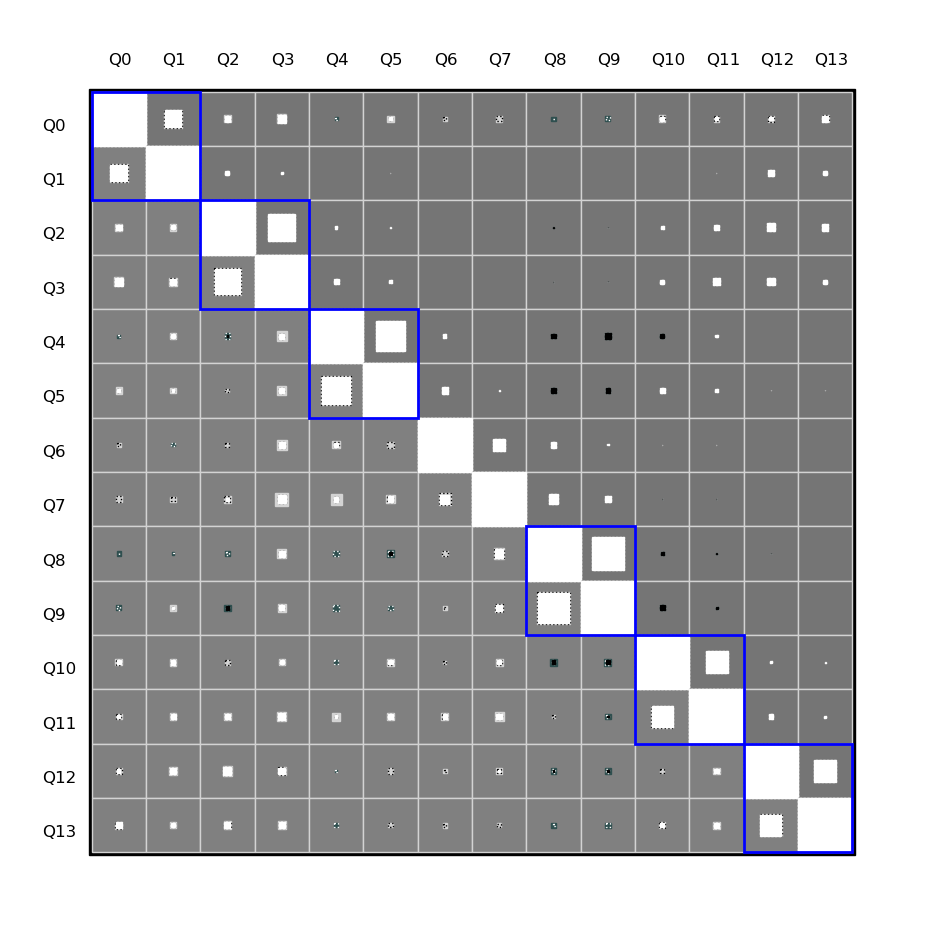

In [57]:
fig = figure("Slightly larger",figsize=(12,12))
ax=gca()
corrmat1= correlationMatrix(ppsVersion1);
c1Gibbs = gibbsRandomField(ppsVersion1,constraints)
ReconstructedPps1 = [getGrainedP(c1Gibbs,tomatch,constraints) for tomatch=0:(2^14-1)]
corrmat1a = correlationMatrix(ReconstructedPps1)

corrmatR = copy(corrmat1)
corrmatRH = copy(highCorrSingle1)
corrmatRL = copy(lowCorrSingle1)

for i=2:14
    for j = i:14
        corrmatR[i,j]= corrmat1a[i,j]
        corrmatRH[i,j]=corrmat1a[i,j]
        corrmatRL[i,j]=corrmat1a[i,j]
    end
end

covhinton(corrmatR,1,ax,
    highCorr=corrmatRH,
    lowCorr=corrmatRL,
    addAxis=true,adjust=0.8,addOneAxis=true,
            stagger=false,voffset=0.4,altColor="#757575")
for x in draw1
    rect = plt.Rectangle([x[1]+1.5,x[1]+1.5], 2, 2, facecolor="none",edgecolor="blue",linewidth=2)
    ax.add_patch(rect)
end
#fig = figure("Slightly larger",figsize=(12,12))
#PyPlot.savefig("./SavedPDFs/CmatrixTwoQubitIntVersion1_2Sigma_C.pdf", bbox_inches = "tight", pad_inches = 0)
#PyPlot.savefig("./SavedPNGs/CmatrixTwoQubitIntVersion1_2Sigma_C.png", bbox_inches = "tight", pad_inches = 0)






### Run 2

[0, 1, 2, 3, 4, 10, 5, 9, 6, 8, 7, 11, 12, 13]

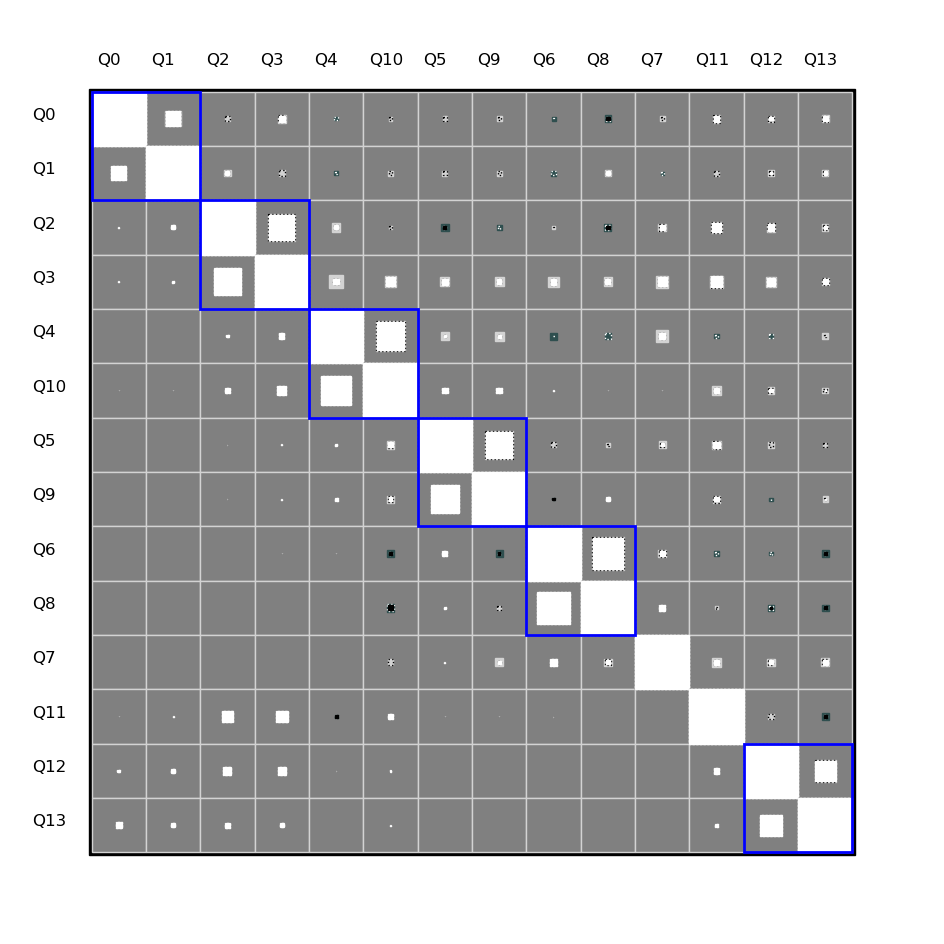

In [58]:
fig = figure("Slightly larger",figsize=(12,12))
ax=gca()
corrmat2= correlationMatrix(ppsVersion2);
c2Gibbs = gibbsRandomField(ppsVersion2,constraints)
ReconstructedPps2 = [getGrainedP(c2Gibbs,tomatch,constraints) for tomatch=0:(2^14-1)]
corrmat2b = correlationMatrix(ReconstructedPps2)

corrmatR2 = copy(corrmat2)
corrmatRH2 = copy(highCorrSingle2)
corrmatRL2 = copy(lowCorrSingle2)

for i=2:14
    for j = 1:i
        corrmatR2[i,j]= corrmat2b[i,j]
        corrmatRH2[i,j]=corrmat2b[i,j]
        corrmatRL2[i,j]=corrmat2b[i,j]
    end
end

ind = [i for i=0:13]
xind = [i for i=0:13]
swapsies = [(6,11),(7,11),(8,10),(9,11),(10,11)]
corrmatR2_Reorder = copy(corrmatR2)
corrmatRH2_Reorder = copy(corrmatRH2)
corrmatRL2_Reorder = copy(corrmatRL2)

for (a,b) in swapsies
    swapRowsAndColumns!(corrmatR2_Reorder,ind,a,b)
    swapRowsAndColumns!(corrmatRH2_Reorder,ind,a,b)
    swapRowsAndColumns!(corrmatRL2_Reorder,ind,a,b)
end
    

print(ind)

fig = figure("Slightly larger",figsize=(12,12))
ax=gca()
covhinton(corrmatR2_Reorder,1,ax,
    highCorr=corrmatRH2_Reorder,
    lowCorr=corrmatRL2_Reorder,
    addAxis=true,adjust=0.6,
    voffset=0.4,addOneAxis=true,ind=ind,stagger=false)

for x in [[0,1],[2,3],[4,5],[6,7],[8,9],[12,13]]
    rect = plt.Rectangle([x[1]+1.5,x[1]+1.5], 2, 2, facecolor="none",edgecolor="blue",linewidth=2)
    ax.add_patch(rect)
end

#PyPlot.savefig("./SavedPDFs/CmatrixTwoQubitIntVersionR2_2Sigma_C.pdf", bbox_inches = "tight", pad_inches = 0)
#PyPlot.savefig("./SavedPNGs/CmatrixTwoQubitIntVersionR2_2Sigma_C.png", bbox_inches = "tight", pad_inches = 0)



### Run 3

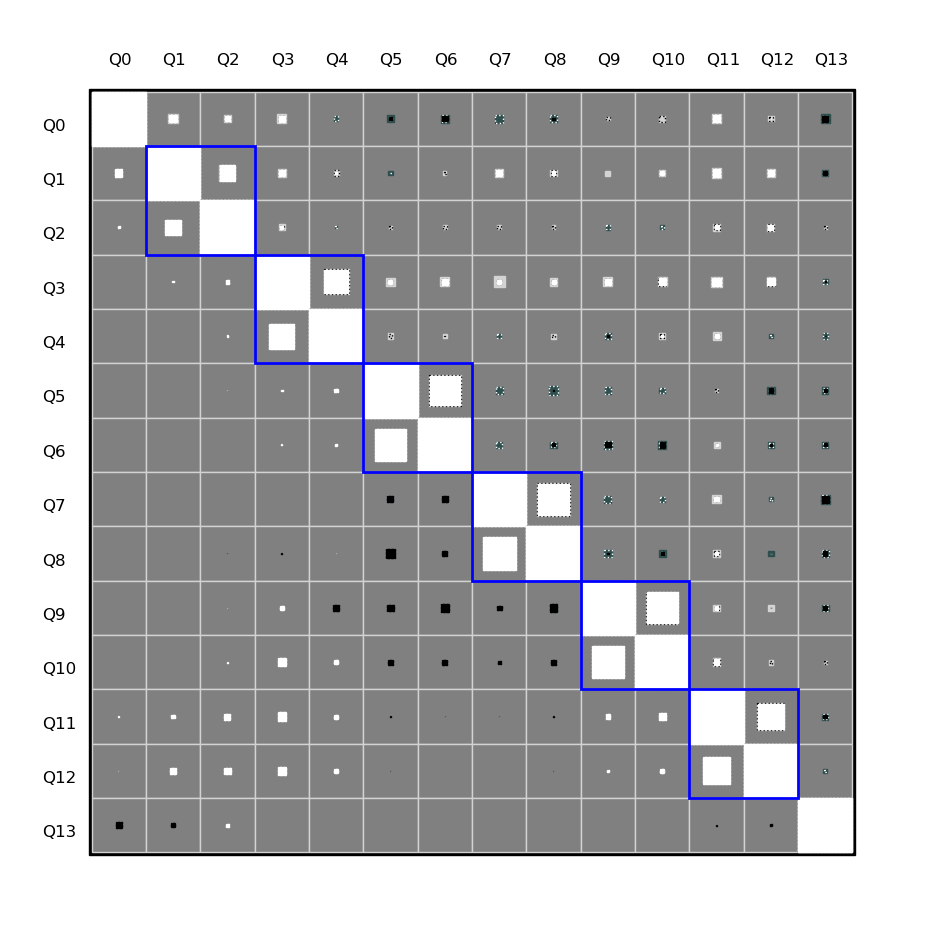

In [59]:
fig = figure("Slightly larger",figsize=(12,12))
ax=gca()
corrmat3= correlationMatrix(ppsVersion3);
c1Gibbs3 = gibbsRandomField(ppsVersion3,constraints)
ReconstructedPps3 = [getGrainedP(c1Gibbs3,tomatch,constraints) for tomatch=0:(2^14-1)]
corrmat3a = correlationMatrix(ReconstructedPps3)

corrmatR3 = copy(corrmat3)
corrmatRH3 = copy(highCorrSingle3)
corrmatRL3 = copy(lowCorrSingle3)

for i=2:14
    for j = 1:i
        corrmatR3[i,j]= corrmat3a[i,j]
        corrmatRH3[i,j]=corrmat3a[i,j]
        corrmatRL3[i,j]=corrmat3a[i,j]
    end
end

covhinton(corrmatR3,1,ax,
    highCorr=corrmatRH3,
    lowCorr=corrmatRL3,
    addAxis=true,adjust=0.8,addOneAxis=true,
            stagger=false,voffset=0.4)
for x in draw3
    rect = plt.Rectangle([x[1]+1.5,x[1]+1.5], 2, 2, facecolor="none",edgecolor="blue",linewidth=2)
    ax.add_patch(rect)
end
#fig = figure("Slightly larger",figsize=(12,12))
#PyPlot.savefig("./SavedPDFs/CmatrixTwoQubitIntVersion1_2Sigma_C.pdf", bbox_inches = "tight", pad_inches = 0)
#PyPlot.savefig("./SavedPNGs/CmatrixTwoQubitIntVersion1_2Sigma_C.png", bbox_inches = "tight", pad_inches = 0)







# Some additional stuff

### Below we extract some information specifically about qubit 3,

In [60]:
generalisedConstraints =[
                            [[1,],[2,14]],
                            [[2,14],[13,3]],
                            [[13,3],[4,12]],
                            [[4,12],[5,11]],
                            [[5,11],[6,10]],
                            [[6,10],[7,9]],
                            [[7,9,8],[]]]


ϕ=gibbsRandomField(ppsVersion1,generalisedConstraints) 
# Reconstruct the entire probability distribution using our markov field.
reconstructed = [getGrainedP(ϕ,tomatch,[vcat(x[1],x[2]) for x in generalisedConstraints]) for tomatch =0:(2^14-1)];




bar(0:13,map(x->x>0.9 ? 0 : x,Marginal.correlationMatrix(ppsVersion1)[4,:]),label="Global")
bar(0:13,map(x->x>0.9 ? 0 : x,Marginal.correlationMatrix(reconstructed)[4,:]),color="red",label="Constrained (GRF)")
legend()
xticks(0:13);
xlabel("Qubits")
ylabel("Covariance")
ylim(-0.005,0.06)
savefig("qubit3_twoqubitProtocol.pdf")

LoadError: UndefVarError: Marginal not defined

In [61]:
sum(map(x->x>0.9 ? 0 : x,correlationMatrix(ppsVersion1)[4,:]))-sum(map(x->x>0.9 ? 0 : x,correlationMatrix(reconstructed)[4,:]))

0.10286089959504241